# Libraries

In [1]:
!nvidia-smi

Thu Aug 21 14:14:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P0             48W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
''' Installing some required libraries. '''
%pip install -U transformers -q
%pip install gdown
%pip install torchinfo -q
%pip install wandb
%pip install torchaudio

# Dataset Download

In [3]:
pip install -U torch==2.6.0 torchvision==0.21.0 torchaudio==2.6.0 --index-url https://download.pytorch.org/whl/cu124


Looking in indexes: https://download.pytorch.org/whl/cu124


In [ ]:
# 1) mount Drive 
from google.colab import drive
drive.mount('/content/drive')

# 2) path: copy zip from Drive to local /content (local IO is much faster)    
ZIP_ON_DRIVE = "/content/drive/MyDrive/LibriSpeech_fbank_text.zip"   # ← change to your actual path/file name
ZIP_LOCAL    = "/content/LibriSpeech_fbank_text.zip"
EXTRACT_DIR  = "/content"   # zip top level is LibriSpeech directory
DATA_ROOT    = "/content/LibriSpeech"   # after unzip, data root: LibriSpeech/train-clean-100/{fbank,text}

import os, shutil, zipfile, time, sys
from tqdm import tqdm

# 3) copy to local
if not os.path.exists(ZIP_ON_DRIVE):
    raise FileNotFoundError(f"Not found on Drive: {ZIP_ON_DRIVE}")
shutil.copy2(ZIP_ON_DRIVE, ZIP_LOCAL)
print("✓ Copied to:", ZIP_LOCAL)

# 4) unzip (with progress)
with zipfile.ZipFile(ZIP_LOCAL, 'r') as zf:
    members = zf.infolist()
    print(f"Unzipping {len(members)} files to {EXTRACT_DIR} ...")
    for m in tqdm(members, total=len(members), unit="files"):
        zf.extract(m, EXTRACT_DIR)

In [ ]:


from google.colab import drive
drive.mount('/content/drive')

import os, torchaudio
DATA_ROOT = "/content/drive/MyDrive/datasets/LibriSpeech"  # all Colab use this
os.makedirs(DATA_ROOT, exist_ok=True)

from torchaudio.datasets import LIBRISPEECH
# train set (start from 100h, want 460h, download 360h)
_ = LIBRISPEECH(DATA_ROOT, url="train-clean-100", download=True)
# _ = LIBRISPEECH(DATA_ROOT, url="train-clean-360", download=True)
# _ = LIBRISPEECH(DATA_ROOT, url="train-other-500", download=True)

# verify/test
_ = LIBRISPEECH(DATA_ROOT, url="dev-clean",  download=True)
_ = LIBRISPEECH(DATA_ROOT, url="dev-other",  download=True)
_ = LIBRISPEECH(DATA_ROOT, url="test-clean", download=True)
_ = LIBRISPEECH(DATA_ROOT, url="test-other", download=True)


##  Imports

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.functional as aF
import torchaudio.transforms as tat
from torch.autograd import Variable
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import TensorDataset, Dataset, DataLoader
import gc
import os
from transformers import AutoTokenizer
import yaml
import math
from typing import Literal, List, Optional, Any, Dict, Tuple
import random
import zipfile
import datetime
from torchinfo import summary
import glob
import wandb
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.fftpack import dct
import seaborn as sns
import matplotlib.pyplot as plt
''' Imports for decoding and distance calculation. '''
import json
import warnings
import shutil
warnings.filterwarnings("ignore")

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", device)

Device:  cuda


# Configurations

## Please read the writeup to understand the following configurations.

In [ ]:
%%writefile config.yaml

Name                      : "Reduced Transformer Model"
###### Dataset -----------------------------------------------------------------
root                      : "/content"

unpaired_text_partition   : "text-for-LM"
train_partition           : "train-clean-100"   # (want 460h, later change to "train-clean-100,train-clean-360")
val_partition             : "dev-clean"
test_partition            : "test-clean"
test_partition_other      : "test-other"
NUM_WORKERS               : 4
subset                    : 1.0
token_type                : "1k"
feat_type                 : 'fbank'
num_feats                 : 80
batch_size                : 16
norm                      : 'cepstral'


###### SpecAugment ---------------------------------------------------------------
specaug                   : True
specaug_conf:
  apply_freq_mask         : True
  freq_mask_width_range   : 4
  num_freq_mask           : 4
  apply_time_mask         : True
  time_mask_width_range   : 50
  num_time_mask           : 8

###### Network Specs -------------------------------------------------------------
d_model                   : 384        # Reduced from 512
d_ff                      : 1536       # Adjusted proportionally (4 * d_model)

###### Embedding Specs -----------------------------------------------------------
time_stride               : 4
feature_stride            : 2
embed_dropout             : 0.1        # Reduced from 0.15

###### Encoder Specs -------------------------------------------------------------
enc_dropout               : 0.1        # Reduced from 0.15
enc_num_layers            : 4          # Reduced from 6
enc_num_heads             : 8          # Reduced from 12

###### Decoder Specs -------------------------------------------------------------
dec_dropout               : 0.1        # Reduced from 0.15
dec_num_layers            : 4          # Reduced from 6
dec_num_heads             : 8          # Reduced from 12

###### Base Parameters -----------------------------------------------------------
use_wandb                 : True
use_ctc                   : False
ctc_weight                : 0.0
optimizer                 : "AdamW"
momentum                  : 0.0
nesterov                  : True
learning_rate             : 2E-4
scheduler                 : "WarmupCosine"
warmup_ratio              : 0.1
factor                    : 0.2
patience                  : 3
epochs                    : 60

Overwriting config.yaml


In [6]:
with open("config.yaml") as file:
    config = yaml.safe_load(file)

In [7]:
config

{'Name': 'Reduced Transformer Model',
 'root': '/content',
 'unpaired_text_partition': 'text-for-LM',
 'train_partition': 'train-clean-100',
 'val_partition': 'dev-clean',
 'test_partition': 'test-clean',
 'test_partition_other': 'test-other',
 'NUM_WORKERS': 4,
 'subset': 1.0,
 'token_type': '1k',
 'feat_type': 'fbank',
 'num_feats': 80,
 'batch_size': 16,
 'norm': 'cepstral',
 'specaug': True,
 'specaug_conf': {'apply_freq_mask': True,
  'freq_mask_width_range': 4,
  'num_freq_mask': 4,
  'apply_time_mask': True,
  'time_mask_width_range': 50,
  'num_time_mask': 8},
 'd_model': 384,
 'd_ff': 1536,
 'time_stride': 4,
 'feature_stride': 2,
 'embed_dropout': 0.1,
 'enc_dropout': 0.1,
 'enc_num_layers': 4,
 'enc_num_heads': 8,
 'dec_dropout': 0.1,
 'dec_num_layers': 4,
 'dec_num_heads': 8,
 'use_wandb': True,
 'use_ctc': False,
 'ctc_weight': 0.0,
 'optimizer': 'AdamW',
 'momentum': 0.0,
 'nesterov': True,
 'learning_rate': '2E-4',
 'scheduler': 'WarmupCosine',
 'warmup_ratio': 0.1,
 'fa

# Tokenization in Speech Recognition

### Tokenizer Options:
Char based, 1k, 10k, [20k, 50k, 100k] (if your memory supports)


In [ ]:
import re
from typing import List, Optional, Literal, Union
import torch
from transformers import AutoTokenizer

class CharTokenizer:
    def __init__(self):
        self.eos_token = "<|endoftext|>"
        self.pad_token = "<|padding|>"
        self.unk_token = "<|unknown|>"
        self.bos_token = self.eos_token  # compatible with old ckpt (BOS=EOS)

        chars = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ '")
        self.vocab = {self.eos_token:0, self.pad_token:1, self.unk_token:2}
        for i,ch in enumerate(chars, start=3): self.vocab[ch]=i
        self.inv_vocab = {v:k for k,v in self.vocab.items()}

        self.eos_token_id = self.vocab[self.eos_token]
        self.bos_token_id = self.vocab[self.bos_token]
        self.pad_token_id = self.vocab[self.pad_token]
        self.unk_token_id = self.vocab[self.unk_token]
        self.vocab_size   = len(self.vocab)

    def tokenize(self, s:str) -> List[str]: return list(s)
    def encode(self, s:str, return_tensors:Optional[Literal['pt']]=None):
        ids = [self.vocab.get(ch.upper(), self.unk_token_id) for ch in s]
        return torch.tensor(ids).unsqueeze(0) if return_tensors=='pt' else ids
    def decode(self, seq:Union[List[int], torch.Tensor]) -> str:
        if isinstance(seq, torch.Tensor): seq = seq.cpu().tolist()
        return "".join(self.inv_vocab.get(int(i), self.unk_token) for i in seq)

class GTokenizer:
    """
    token_type: 'char' | '1k' | '50k' | '10k' | '20k' | '100k'
    normalize_case: 'none' | 'lower' | 'upper'
    """
    REPOS = {
        '1k':   "alexgichamba/hw4_tokenizer_1k",
        '10k':  "alexgichamba/hw4_tokenizer_10k",
        '20k':  "alexgichamba/hw4_tokenizer_20k",
        '50k':  "alexgichamba/hw4_tokenizer_50k",
        '100k': "alexgichamba/hw4_tokenizer_100k",
    }
    def __init__(self, token_type: Literal['char','1k','10k','20k','50k','100k']='char',
                 normalize_case: Literal['none','lower','upper']='none'):
        self.token_type = token_type
        self.normalize_case = normalize_case

        if token_type == 'char':
            self.tokenizer = CharTokenizer()
        else:
            repo = self.REPOS[token_type]
            tk = AutoTokenizer.from_pretrained(repo, use_fast=False)

            # ensure PAD; if not, inject one
            if tk.pad_token_id is None:
                tk.add_special_tokens({'pad_token': '<|padding|>'})
            # ensure EOS; if not, inject one
            if tk.eos_token_id is None:
                tk.add_special_tokens({'eos_token': '<|endoftext|>'})
            # ensure BOS; if not, use EOS as fallback (same as old logic)
            if tk.bos_token_id is None:
                tk.add_special_tokens({'bos_token': tk.eos_token or '<|endoftext|>'})

            self.tokenizer = tk  # HF tokenizer

        # export fields
        self.EOS_TOKEN  = self.tokenizer.eos_token_id
        self.SOS_TOKEN  = self.tokenizer.bos_token_id
        self.PAD_TOKEN  = (self.tokenizer.pad_token_id if self.token_type=='char'
                           else self.tokenizer.pad_token_id)
        self.UNK_TOKEN  = getattr(self.tokenizer, 'unk_token_id', None)
        self.VOCAB_SIZE = getattr(self.tokenizer, 'vocab_size', None)

        # smoke test
        sample = "Hi Deep Learners"
        enc = self.encode(sample)
        dec = self.decode(enc)
        print(f"[Tokenizer Loaded] type={token_type} V={self.VOCAB_SIZE} PAD={self.PAD_TOKEN} EOS/SOS={self.EOS_TOKEN}/{self.SOS_TOKEN}")
        print(f"ex: '{sample}' -> {enc[:16]} -> '{dec[:32]}'")

    def _maybe_norm(self, s:str) -> str:
        if self.normalize_case == 'lower': return s.lower()
        if self.normalize_case == 'upper': return s.upper()
        return s

    def tokenize(self, s:str) -> List[str]:
        s = self._maybe_norm(s)
        return (self.tokenizer.tokenize(s) if self.token_type!='char'
                else self.tokenizer.tokenize(s))

    def encode(self, s:str, return_tensors:Optional[Literal['pt']]=None):
        s = self._maybe_norm(s)
        if self.token_type == 'char':
            return self.tokenizer.encode(s, return_tensors=('pt' if return_tensors else None))
        # key: no special tokens, add <SOS>/<EOS> in Dataset
        ids = self.tokenizer.encode(s, add_special_tokens=False)
        if return_tensors == 'pt': return torch.tensor(ids).unsqueeze(0)
        return ids

    def decode(self, ids) -> str:
        if self.token_type == 'char':
            return self.tokenizer.decode(ids)
        if isinstance(ids, torch.Tensor): ids = ids.cpu().tolist()
        # key: skip special tokens, avoid decoding <pad> etc.
        return self.tokenizer.decode(ids, skip_special_tokens=True)


## Instantiate your tokenizer of choice

In [9]:
Tokenizer = GTokenizer(token_type='1k', normalize_case='lower')  # 若你的转写存的是大写，建议 lower


[Tokenizer Loaded] type=1k V=1000 PAD=1 EOS/SOS=0/0
ex: 'Hi Deep Learners' -> [73, 74, 222, 69, 70, 70, 81, 222, 77, 70, 66, 83, 79, 70, 83, 84] -> 'hi deep learners'


# Data

## Speech Features - Text Paired Dataset (TODO)
The `SpeechDataset` class is a PyTorch `Dataset` for loading, processing, and preparing speech data. It handles feature extraction, tokenization, and optional feature augmentation, specifically for speech-based tasks.
You will use this to train a Transformer ASR model.

In [ ]:
import os, json, random
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torchaudio.transforms as tat
from scipy.fftpack import dct
from typing import List, Optional, Literal
from tqdm import tqdm   # ← only add this line
# ------------------------------
# reproducible: small tool to fix random seed
# ------------------------------
def make_worker_init_fn(SEED:int):
    def _fn(worker_id):
        s = SEED + worker_id
        random.seed(s); np.random.seed(s); torch.manual_seed(s)
    return _fn

def make_dataloader(dataset: Dataset, batch_size: int, shuffle: bool, num_workers: int, SEED: int):
    g = torch.Generator()
    g.manual_seed(SEED)
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=True,
        collate_fn=dataset.collate_fn,
        generator=g,
        worker_init_fn=make_worker_init_fn(SEED),
        persistent_workers=(num_workers > 0),
    )

def dump_manifest(dataset: "SpeechDataset", save_path: str):
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    with open(save_path, "w") as f:
        for fn in dataset.fbank_files:
            f.write(fn + "\n")



class SpeechDataset(Dataset):
    """
    read fbank/*.npy, text/*.npy; feature padding=0.0; label padding=tokenizer.PAD.
    same as before, just add tqdm progress bar when loading.
    """
    def __init__(self,
                 partition: Literal['train-clean-100', 'dev-clean', 'test-clean', 'test-other'],
                 config: dict,
                 tokenizer,
                 isTrainPartition: bool,
                 manifest_path: Optional[str] = None,
                 show_progress: bool = False   # ← new switch; default not show
                 ):
        super().__init__()
        # --- basic config ---
        self.config           = config
        self.root             = self.config['root']
        self.partition        = partition
        self.isTrainPartition = isTrainPartition
        self.tokenizer        = tokenizer

        self.eos_token = tokenizer.EOS_TOKEN
        self.sos_token = tokenizer.SOS_TOKEN
        self.pad_token = tokenizer.PAD_TOKEN

        self.subset    = float(self.config.get('subset', 1.0))
        self.feat_type = self.config.get('feat_type', 'fbank')   # 'fbank' | 'mfcc'
        self.num_feats = int(self.config.get('num_feats', 80))
        self.norm      = self.config.get('norm', 'cepstral')     # 'cepstral' | 'global_mvn' | 'none'

        # --- 路径与清单 ---
        self.fbank_dir = os.path.join(self.root, self.partition, "fbank")
        assert os.path.isdir(self.fbank_dir), f"fbank dir not found: {self.fbank_dir}"

        if manifest_path and os.path.exists(manifest_path):
            with open(manifest_path) as f:
                files = [ln.strip() for ln in f if ln.strip()]
        else:
            files = sorted(os.listdir(self.fbank_dir))
        if self.subset < 1.0:
            files = files[: int(len(files) * self.subset)]

        # only keep .npy
        self.fbank_files = [fn for fn in files if fn.endswith(".npy")]
        assert len(self.fbank_files) > 0, f"No .npy found in {self.fbank_dir}"

        self.text_dir = os.path.join(self.root, self.partition, "text")
        self.has_text = os.path.isdir(self.text_dir) and len(os.listdir(self.text_dir)) > 0
        # if you want to be more strict, you can check if the number of files with the same name as fbank is greater than 0:
        # self.has_text = os.path.isdir(self.text_dir) and any(fn.endswith(".npy") for fn in os.listdir(self.text_dir))


        # --- load to memory (no change in logic, just add progress bar)---
        self.feats: List[np.ndarray] = []
        self.transcripts_shifted: List[np.ndarray] = []
        self.transcripts_golden:  List[np.ndarray] = []

        iterator = self.fbank_files
        if show_progress:
            iterator = tqdm(iterator, total=len(iterator),
                            desc=f"[{self.partition}] loading", ncols=0)

        for fn in iterator:
            # 读 fbank: [F, T]
            fpath = os.path.join(self.fbank_dir, fn)
            feat = np.load(fpath)  # [F, T]

            if self.feat_type == 'mfcc':
                feat = self.fbank_to_mfcc(feat)  # 仍 [F, T]

            feat = feat[:self.num_feats, :]

            # in SpeechDataset.__init__, after loading single feat:
            if self.norm == 'cepstral':
                feat = (feat - feat.mean(axis=0, keepdims=True)) / (feat.std(axis=0, keepdims=True) + 1e-8)


            self.feats.append(feat)

            if self.has_text:

                tpath = os.path.join(self.text_dir, fn)

                # allow deserialization of object arrays (character lists)
                arr = np.load(tpath, allow_pickle=True)

                # compatible with multiple save forms -> get pure string
                if isinstance(arr, np.ndarray):
                    if arr.ndim == 0:                          # single string
                        text = str(arr.item())
                    else:                                      # character/string list
                        text = "".join(map(str, arr.tolist()))
                else:
                    text = str(arr)

                token_ids = self.tokenizer.encode(text)

                shifted = np.asarray([self.sos_token] + token_ids, dtype=np.int64)
                golden  = np.asarray(token_ids + [self.eos_token], dtype=np.int64)
                self.transcripts_shifted.append(shifted)
                self.transcripts_golden.append(golden)

        self.length = len(self.feats)

        # --- global MVN (optional)---
        self.global_mean = None
        self.global_std  = None
        if self.norm == 'global_mvn':
            self.global_mean, self.global_std = self.compute_global_stats()

        # --- SpecAug (only train set)---
        self.time_mask = None
        self.freq_mask = None
        if self.config.get("specaug", False) and self.isTrainPartition:
            sac = self.config["specaug_conf"]
            if sac.get("apply_time_mask", False):
                self.time_mask = tat.TimeMasking(time_mask_param=int(sac["time_mask_width_range"]), iid_masks=True)
            if sac.get("apply_freq_mask", False):
                self.freq_mask = tat.FrequencyMasking(freq_mask_param=int(sac["freq_mask_width_range"]), iid_masks=True)
        self.num_time_mask = int(self.config.get("specaug_conf", {}).get("num_time_mask", 0))
        self.num_freq_mask = int(self.config.get("specaug_conf", {}).get("num_freq_mask", 0))

    # other methods remain unchanged ↓↓↓
    def __len__(self): return self.length

    def __getitem__(self, idx):
        feat = torch.tensor(self.feats[idx], dtype=torch.float32)
        if (self.global_mean is not None) and (self.global_std is not None):
            feat = (feat - self.global_mean.unsqueeze(1)) / (self.global_std.unsqueeze(1) + 1e-8)
        if self.has_text:
            shifted = torch.tensor(self.transcripts_shifted[idx], dtype=torch.long)
            golden  = torch.tensor(self.transcripts_golden[idx],  dtype=torch.long)
        else:
            shifted, golden = None, None
        return feat, shifted, golden

    def collate_fn(self, batch):
        feats, shifted_list, golden_list = zip(*batch)
        feats_TF = [x.transpose(0, 1) for x in feats]          # [T, F]
        len_feats = torch.tensor([x.size(0) for x in feats_TF], dtype=torch.long)
        batch_feats_pad = pad_sequence(feats_TF, batch_first=True, padding_value=0.0)  # [B,T,F]
        if self.isTrainPartition and (self.time_mask or self.freq_mask):
            x = batch_feats_pad.transpose(1, 2)
            if self.freq_mask is not None:
                for _ in range(self.num_freq_mask): x = self.freq_mask(x)
            if self.time_mask is not None:
                for _ in range(self.num_time_mask): x = self.time_mask(x)
            batch_feats_pad = x.transpose(1, 2)
        if self.has_text:
            batch_shift_pad = pad_sequence(list(shifted_list), batch_first=True, padding_value=self.pad_token)
            batch_gold_pad  = pad_sequence(list(golden_list),  batch_first=True, padding_value=self.pad_token)
            len_trans = torch.tensor([x.size(0) for x in shifted_list], dtype=torch.long)
            return batch_feats_pad, batch_shift_pad, batch_gold_pad, len_feats, len_trans
        else:
            return batch_feats_pad, None, None, len_feats, None

    @staticmethod
    def fbank_to_mfcc(fbank: np.ndarray) -> np.ndarray:
        return dct(fbank.T, type=2, axis=1, norm='ortho').T

    def compute_global_stats(self):
        frames = []
        for arr in self.feats:  # [F,T]
            frames.append(torch.tensor(arr, dtype=torch.float32).transpose(0, 1))  # [T,F]
        big = torch.cat(frames, dim=0)
        mean = big.mean(dim=0); std = big.std(dim=0)
        return mean, std

    def __repr__(self) -> str:
        return (f"SpeechDataset(partition={self.partition}, N={len(self)}, "
                f"feat_type={self.feat_type}, num_feats={self.num_feats}, "
                f"norm={self.norm}, specaug={self.isTrainPartition and (self.time_mask or self.freq_mask) is not None})")



## Text Unpaired Dataset (Decoder LM Pre-Training)
The `TextDataset` class is a PyTorch `Dataset` for handling text data. It loads and tokenizes text transcripts from files, applies start-of-sequence and end-of-sequence tokens, and provides methods to retrieve and batch data.
You will use this to pre-train a Transformer decoder as an LM before optionally using it along with the Encoder for the ASR task

In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from typing import List, Tuple, Optional

class TextDataset(Dataset):
    """
    仅文本的 LM 预训练数据集：
    - 读取 root/<partition> 下的 .npy 文本（与课程数据一致）
    - 支持 subset 裁剪
    - robust 处理：.npy 里可能是 list[char]、list[str] 或 str
    - shifted:  [SOS] + ids
      golden :  ids + [EOS]
    - collate_fn 返回 (shift_pad, golden_pad, len_shift)
    """
    def __init__(self,
                 partition: str,          # suggest pass config['unpaired_text_partition'], e.g. "text-for-LM"
                 config: dict,
                 tokenizer,               # your GTokenizer / CharTokenizer
                 manifest_path: Optional[str] = None):
        super().__init__()
        self.root      = config['root']
        self.subset    = float(config.get('subset', 1.0))
        self.partition = partition
        self.tokenizer = tokenizer

        self.eos_token = tokenizer.EOS_TOKEN
        self.sos_token = tokenizer.SOS_TOKEN
        self.pad_token = tokenizer.PAD_TOKEN

        # --- list directory (or use manifest to lock order)
        self.text_dir = os.path.join(self.root, self.partition)
        assert os.path.isdir(self.text_dir), f"Text dir not found: {self.text_dir}"

        if manifest_path and os.path.exists(manifest_path):
            with open(manifest_path) as f:
                files = [ln.strip() for ln in f if ln.strip()]
        else:
            files = sorted(os.listdir(self.text_dir))

        files = [fn for fn in files if fn.endswith(".npy")]
        if self.subset < 1.0:
            files = files[: int(len(files) * self.subset)]
        self.text_files = files
        self.length     = len(self.text_files)

        # preload to memory (convenient and stable when data is not large)
        self.transcripts_shifted: List[np.ndarray] = []
        self.transcripts_golden:  List[np.ndarray] = []

        for fn in self.text_files:
            arr = np.load(os.path.join(self.text_dir, fn), allow_pickle=True)
            # robust -> str
            if isinstance(arr, np.ndarray):
                arr = arr.tolist()
            if isinstance(arr, list):
                # maybe list[char] or list[str]
                text = "".join(arr) if all(isinstance(x, str) and len(x) == 1 for x in arr) else " ".join(arr)
            else:
                text = str(arr)

            # unify whitespace
            text = " ".join(text.split())

            ids = self.tokenizer.encode(text)  # List[int]
            shifted = np.asarray([self.sos_token] + ids, dtype=np.int64)   # <SOS> + ...
            golden  = np.asarray(ids + [self.eos_token], dtype=np.int64)   # ... + <EOS>
            self.transcripts_shifted.append(shifted)
            self.transcripts_golden.append(golden)

    def __len__(self) -> int:
        return self.length

    def __getitem__(self, idx: int) -> Tuple[torch.LongTensor, torch.LongTensor]:
        shifted = torch.tensor(self.transcripts_shifted[idx], dtype=torch.long)
        golden  = torch.tensor(self.transcripts_golden[idx],  dtype=torch.long)
        return shifted, golden

    def collate_fn(self, batch: List[Tuple[torch.LongTensor, torch.LongTensor]]
                   ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        batch_shift   = [b[0] for b in batch]
        batch_golden  = [b[1] for b in batch]
        len_shift     = torch.tensor([x.size(0) for x in batch_shift], dtype=torch.long)

        batch_shift_pad  = pad_sequence(batch_shift,  batch_first=True, padding_value=self.pad_token)
        batch_golden_pad = pad_sequence(batch_golden, batch_first=True, padding_value=self.pad_token)
        return batch_shift_pad, batch_golden_pad, len_shift


## Datasets

In [ ]:
# ==== one-time preprocessing: wav -> fbank/*.npy + text/*.npy ====
import os, numpy as np, torch, torchaudio
from torchaudio.datasets import LIBRISPEECH
from tqdm import tqdm

DATA_ROOT = "/content/drive/MyDrive/datasets/LibriSpeech"  # your download path
NUM_FEATS = int(config.get("num_feats", 80))               # align with config.yaml

def compute_fbank(waveform: torch.Tensor, sr: int, num_mel_bins: int = 80) -> np.ndarray:
    if sr != 16000:
        waveform = torchaudio.functional.resample(waveform, sr, 16000)
        sr = 16000
    # ensure single channel shape [1, T]
    if waveform.dim() == 1:
        waveform = waveform.unsqueeze(0)
    elif waveform.dim() == 2 and waveform.size(0) > 1:
        waveform = waveform.mean(0, keepdim=True)

    feat = torchaudio.compliance.kaldi.fbank(
        waveform, sample_frequency=sr, num_mel_bins=num_mel_bins,
        frame_length=25, frame_shift=10, dither=0.0, energy_floor=0.0
    )
    return feat.transpose(0, 1).numpy().astype(np.float32)  # [num_feats, T]

def prepare_split(root: str, split: str, num_feats: int):
    ds = LIBRISPEECH(root, url=split, download=False)
    out_f = os.path.join(root, split, "fbank")
    out_t = os.path.join(root, split, "text")
    os.makedirs(out_f, exist_ok=True); os.makedirs(out_t, exist_ok=True)
    print(f"[prep] {split}: {len(ds)} items -> {out_f} / {out_t}")

    for wav, sr, transcript, spk, chap, utt in tqdm(ds):
        uid = f"{spk}-{chap}-{utt}"
        fpath = os.path.join(out_f, uid + ".npy")
        tpath = os.path.join(out_t, uid + ".npy")

        if not os.path.exists(fpath):
            fb = compute_fbank(wav, sr, num_mel_bins=num_feats)   # ← here to change keyword
            np.save(fpath, fb)

        if not os.path.exists(tpath):
            # your SpeechDataset use np.load(...).tolist() then "".join()
            # save as 0-D numpy string, compatible with existing read logic
            np.save(tpath, np.array(transcript))

# need which split, call which (first run train-clean-100 / dev-clean, then test-*)
for split in ["train-clean-100", "dev-clean", "test-clean", "test-other"]:
    prepare_split(DATA_ROOT, split, NUM_FEATS)


In [ ]:
# =========================
# Datasets
# =========================
train_dataset = SpeechDataset(
    partition        = config['train_partition'],
    config           = config,
    tokenizer        = Tokenizer,
    isTrainPartition = True,
    show_progress    = True,  
)

val_dataset = SpeechDataset(
    partition        = config['val_partition'],
    config           = config,
    tokenizer        = Tokenizer,
    isTrainPartition = False,
    show_progress    = True,   # ← if you want to see, open; if not, False
)

test_dataset = SpeechDataset(
    partition        = config['test_partition'],
    config           = config,
    tokenizer        = Tokenizer,
    isTrainPartition = False,
    show_progress    = True,
)


[train-clean-100] loading: 100% 28539/28539 [00:53<00:00, 531.08it/s]
[dev-clean] loading: 100% 2703/2703 [00:03<00:00, 757.25it/s]
[test-clean] loading: 100% 2620/2620 [00:03<00:00, 732.08it/s]


## DataLoaders

In [ ]:


# =========================
# Reproducible DataLoaders
# =========================
SEED = int(config.get('seed', 1337))

def _worker_init_fn(worker_id: int):
    # make each worker have deterministic seed (avoid order drift after adding/removing workers)
    base = SEED + worker_id
    random.seed(base)
    np.random.seed(base)
    torch.manual_seed(base)

def _make_loader(dataset, batch_size, shuffle):
    # for "shuffle loader", give a fixed Generator
    gen = None
    if shuffle:
        gen = torch.Generator()
        gen.manual_seed(SEED)

    return DataLoader(
        dataset            = dataset,
        batch_size         = batch_size,
        shuffle            = shuffle,
        num_workers        = int(config['NUM_WORKERS']),
        pin_memory         = (device == 'cuda'),
        collate_fn         = dataset.collate_fn,
        worker_init_fn     = _worker_init_fn,
        generator          = gen,
        persistent_workers = (int(config['NUM_WORKERS']) > 0),
        # drop_last       = False,   # if you want to strictly align the size of each step, you can open
    )

train_loader = _make_loader(train_dataset, int(config["batch_size"]), True)
val_loader   = _make_loader(val_dataset,   4,                           False)
test_loader  = _make_loader(test_dataset,  int(config["batch_size"]),   False)

# (optional) LM pre-training DataLoader
# text_loader = _make_loader(text_dataset, int(config["batch_size"]), True)


### Dataset Verification and Analysis Overview

This verifies and analyzes properties of both paired (audio-transcript) and unpaired (transcript-only) datasets in a speech-text processing pipeline. The main steps are:



Paired Data Stats: 
No. of Train Feats   : 28539
Batch Size           : 16
Train Batches        : 1784
Val Batches          : 676

Checking the Shapes of the Data --

x_pad shape:		torch.Size([16, 1610, 80])
x_len shape:		torch.Size([16])
y_shifted_pad shape:	torch.Size([16, 264])
y_golden_pad shape:	torch.Size([16, 264])
y_len shape:		torch.Size([16])

Transcript Shifted: i must do more rejoined the prince in requital for having saved your life and the respect he has strewn for me to make amends for the loss of his fortune in short to repair the wrong i have done to himself and his family
Transcript Golden : i must do more rejoined the prince in requital for having saved your life and the respect he has strewn for me to make amends for the loss of his fortune in short to repair the wrong i have done to himself and his family



Verifying Datasets
Loaded Path: train-clean-100


Verifying train-clean-100 Dataset: 100%|██████████| 1784/1784 [00:20<00:00, 85.63it/s]


Maximum Feat Length in Dataset       : 2451
Maximum Transcript Length in Dataset : 399
Loaded Path: dev-clean


Verifying dev-clean Dataset: 100%|██████████| 676/676 [00:02<00:00, 273.49it/s]


Maximum Feat Length in Dataset       : 3263
Maximum Transcript Length in Dataset : 517
Loaded Path: test-clean


Verifying test-clean Dataset: 100%|██████████| 164/164 [00:01<00:00, 107.99it/s]


Maximum Feat Length in Dataset       : 3494
Maximum Transcript Length in Dataset : 577
Maximum Feat. Length in Entire Dataset      : 3494
Maximum Transcript Length in Entire Dataset : 517



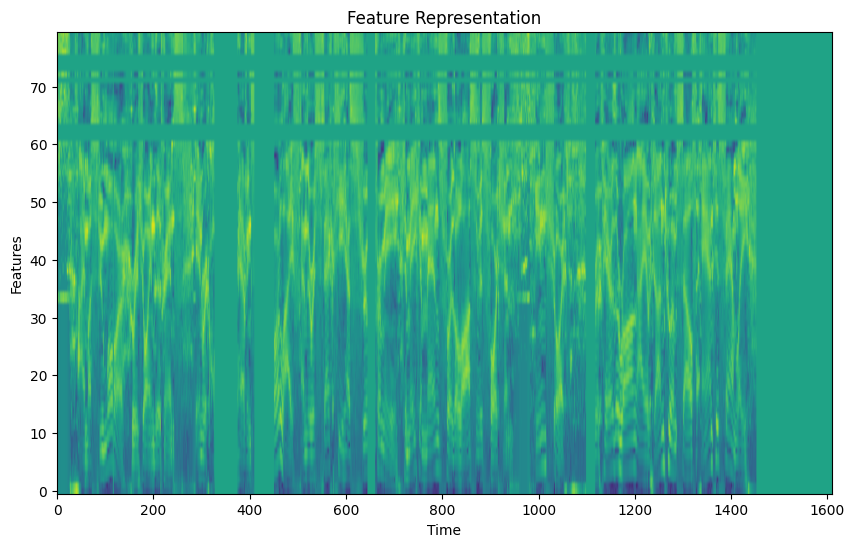

In [ ]:
def verify_dataset(dataloader, partition: str):
    """Compute the maximum feature length (T_feat) and transcript length (T_text) in a dataset."""
    print("Loaded Path:", partition)
    max_len_feat = 0
    max_len_t    = 0

    for batch in tqdm(dataloader, desc=f"Verifying {partition} Dataset"):
        # compatible with two batch structures:
        # 1) speech: (x_pad, y_shifted_pad, y_golden_pad, x_len, y_len)
        # 2) textLM: (y_shifted_pad, y_golden_pad, y_len)
        if isinstance(batch, (list, tuple)) and len(batch) == 5:
            x_pad, y_shifted_pad, y_golden_pad, x_len, y_len = batch
            # update longest feature axis
            max_len_feat = max(max_len_feat, int(x_pad.shape[1]))
            # update longest transcript length (may be None, e.g. test-clean)
            if y_shifted_pad is not None:
                max_len_t = max(max_len_t, int(y_shifted_pad.shape[1]))
        elif isinstance(batch, (list, tuple)) and len(batch) == 3:
            # TextDataset case  
            y_shifted_pad, y_golden_pad, y_len = batch
            max_len_t = max(max_len_t, int(y_shifted_pad.shape[1]))
        else:
            raise ValueError(f"Unexpected batch structure for {partition}: len={len(batch)}")

    print(f"Maximum Feat Length in Dataset       : {max_len_feat}")
    print(f"Maximum Transcript Length in Dataset : {max_len_t}")
    return max_len_feat, max_len_t

def _strip_special(ids, pad_id, eos_id, sos_id):
    # remove PAD/SOS/EOS before decoding, for human readability
    return [t for t in ids if t not in (pad_id, eos_id, sos_id)]

print('')
print("Paired Data Stats: ")
print(f"No. of Train Feats   : {len(train_dataset)}")
print(f"Batch Size           : {config['batch_size']}")
print(f"Train Batches        : {len(train_loader)}")
print(f"Val Batches          : {len(val_loader)}")
print('')

print("Checking the Shapes of the Data --\n")
first_train_batch = next(iter(train_loader))
x_pad, y_shifted_pad, y_golden_pad, x_len, y_len = first_train_batch
print(f"x_pad shape:\t\t{x_pad.shape}")    # [B, T_feat, F]
print(f"x_len shape:\t\t{x_len.shape}")    # [B]

if y_shifted_pad is not None and y_golden_pad is not None and y_len is not None:
    print(f"y_shifted_pad shape:\t{y_shifted_pad.shape}")  # [B, T_text]
    print(f"y_golden_pad shape:\t{y_golden_pad.shape}")    # [B, T_text]
    print(f"y_len shape:\t\t{y_len.shape}\n")              # [B]

    # 打印一个可读的样例（剔除特殊符号）
    pad_id, eos_id, sos_id = train_dataset.pad_token, train_dataset.eos_token, train_dataset.sos_token
    ex_shift = _strip_special(y_shifted_pad[0].tolist(), pad_id, eos_id, sos_id)
    ex_golden= _strip_special(y_golden_pad[0].tolist(),  pad_id, eos_id, sos_id)
    print("Transcript Shifted:", train_dataset.tokenizer.decode(ex_shift))
    print("Transcript Golden :", train_dataset.tokenizer.decode(ex_golden))
print('')

print("\n\nVerifying Datasets")
max_train_feat,  max_train_transcript = verify_dataset(train_loader, config['train_partition'])
max_val_feat,    max_val_transcript   = verify_dataset(val_loader,   config['val_partition'])
max_test_feat,   max_test_transcript  = verify_dataset(test_loader,  config['test_partition'])
# _, max_text_transcript = verify_dataset(text_loader,  config['unpaired_text_partition'])  # if you want to LM pre-training, open

MAX_SPEECH_LEN = max(max_train_feat, max_val_feat, max_test_feat)
MAX_TRANS_LEN  = max(max_train_transcript, max_val_transcript)
print(f"Maximum Feat. Length in Entire Dataset      : {MAX_SPEECH_LEN}")
print(f"Maximum Transcript Length in Entire Dataset : {MAX_TRANS_LEN}")
print('')
gc.collect()

# small preview of a feature map
plt.figure(figsize=(10, 6))
plt.imshow(x_pad[0].numpy().T, aspect='auto', origin='lower')
plt.xlabel('Time')
plt.ylabel('Features')
plt.title('Feature Representation')
plt.show()


In [15]:
def audit_unk_ratio(ds, tokenizer, n=5000):
    import numpy as np
    unk = tokenizer.UNK_TOKEN
    tot = unk_cnt = 0
    for i in range(min(n, len(ds))):
        _, _, g = ds[i]
        if g is None: continue
        g = g.numpy()
        unk_cnt += (g == unk).sum()
        tot     += g.size
    print(f"[UNK audit] {unk_cnt}/{tot} = {unk_cnt/max(1,tot):.3%}")

audit_unk_ratio(train_dataset, Tokenizer)


[UNK audit] 0/912763 = 0.000%


In [16]:
import numpy as np, os
k = 0
_, s, g = train_dataset[k]
print("ids[:40] =", g[:40].tolist())
print("dec(txt) =", Tokenizer.decode(g[:200]))


ids[:40] = [68, 73, 66, 81, 85, 70, 83, 222, 80, 79, 70, 222, 78, 74, 84, 84, 86, 84, 222, 83, 66, 68, 73, 70, 77, 222, 77, 90, 79, 69, 70, 222, 74, 84, 222, 84, 86, 83, 81, 83]
dec(txt) = chapter one missus rachel lynde is surprised missus rachel lynde lived just where the avonlea main road dipped down into a little hollow fringed with alders and ladies eardrops and traversed by a broo


## Masking in Transformers for Sequence Modeling


In [ ]:
def PadMask(padded_input: torch.Tensor,
            input_lengths: Optional[torch.Tensor] = None,
            pad_idx: Optional[int] = None) -> torch.Tensor:
    """
    generate Key Padding Mask, shape (N, T), where True means "ignore/not participate in attention".
    - recommend: pass input_lengths (most stable, suitable for speech features)
    - alternative: if lengths is not passed, use pad_idx to infer from discrete tokens
    """
    # unify batch and time dimension
    if padded_input.dim() == 2:
        N, T = padded_input.shape
    else:
        N, T = padded_input.size(0), padded_input.size(1)

    device = padded_input.device

    if input_lengths is not None:
        # construct by length: position >= length → True
        lens = input_lengths.to(device)
        arange = torch.arange(T, device=device).expand(N, T)  # [N, T]
        mask = arange >= lens.unsqueeze(1)                    # True=padding
        return mask.to(torch.bool)

    # if no lengths, must rely on pad_idx (usually discrete token)
    if pad_idx is None:
        raise ValueError("PadMask: provide either input_lengths or pad_idx.")

    # based on pad_idx: only suitable for (N, T) discrete token; if (N, T, 1) can also be processed
    base = padded_input
    if padded_input.dim() > 2:
        base = padded_input.squeeze(-1)  # if (N, T, 1) will be squeezed

    if base.dim() != 2:
        raise ValueError("PadMask: pad_idx mode expects (N, T) or (N, T, 1) tensor.")

    mask = (base == pad_idx)  # True=padding
    return mask.to(torch.bool)


def CausalMask(input_tensor: torch.Tensor) -> torch.Tensor:
    """
    generate causal mask for self-attention, shape (T, T), where True means "forbid" to attend to future positions.
    note: in attn_mask passed to nn.MultiheadAttention, True/non-zero = masked.
    """
    T = int(input_tensor.shape[1])
    # upper triangle (excluding main diagonal) = True (to be masked)
    attn_mask = torch.triu(torch.ones((T, T), dtype=torch.bool, device=input_tensor.device), diagonal=1)
    return attn_mask


## Transformer Modules

### Positional Encoding in Transformers




In [ ]:
import math
import torch
import torch.nn as nn

class PositionalEncoding(nn.Module):
    """Sine-cosine positional encoding (support dynamic length)"""
    def __init__(self, d_model: int, max_len: int = 512):
        super().__init__()
        assert d_model is not None, "d_model must be provided"
        self.d_model = int(d_model)

        pe = self._build_pe(max_len, dtype=torch.float32, d_model=self.d_model)
        # register as buffer, and not persistent (avoid saving large table)
        self.register_buffer("pe", pe, persistent=False)

    @staticmethod
    def _build_pe(L: int, dtype: torch.dtype, d_model: int) -> torch.Tensor:
        assert d_model is not None, "d_model must be provided"
        pe = torch.zeros(L, d_model, dtype=dtype)
        position = torch.arange(0, L, dtype=dtype).unsqueeze(1)               # [L,1]
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=dtype) *
                             (-math.log(10000.0) / d_model))                  # [d_model/2]
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)                                                # [1,L,D]

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # if need longer positional encoding, expand once as needed
        L_needed = x.size(1)
        if self.pe.size(1) < L_needed:
            new_pe = self._build_pe(L_needed, dtype=self.pe.dtype, d_model=self.d_model).to(self.pe.device)
            self.register_buffer("pe", new_pe, persistent=False)

        # align dtype/device before adding
        return x + self.pe[:, :L_needed].to(dtype=x.dtype, device=x.device)


### Speech Embedding Architecture (Conv2D Subsampling + BiLSTM)

This implements a speech embedding module that uses Conv2D-based subsampling followed by a BiLSTM (Bidirectional Long Short-Term Memory) layer to process speech signals. 


In [ ]:
# ========= Embedding (BiLSTM + Conv2D) =========
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# 1) bidirectional LSTM (1 layer; dropout is invalid for 1 layer, so explicitly 0.0)
class BiLSTMEmbedding(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, dropout: float):
        super().__init__()
        self.bilstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=output_dim // 2,   # bidirectional → concatenate to output_dim
            num_layers=1,
            batch_first=True,
            bidirectional=True,
            dropout=0.0
        )

    def forward(self, x: torch.Tensor, x_len: torch.Tensor) -> torch.Tensor:
        # x: [B, T, D_in] (padding done)
        packed = pack_padded_sequence(x, x_len.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, _ = self.bilstm(packed)
        # total_length keep time dimension same as input (not truncated)
        out, _ = pad_packed_sequence(packed_out, batch_first=True, total_length=x.size(1))
        return out


# 2) Conv2D downsampling (2 layers, kernel=3, no padding), with "exact length propagation" function
class Conv2DSubsampling(nn.Module):
    def __init__(self, input_dim: int, output_dim: int,
                 dropout: float = 0.0, time_stride: int = 2, feature_stride: int = 2):
        super().__init__()
        # decompose stride into two layers (balance as much as possible)
        t1, t2 = self._closest_factors(time_stride)
        f1, f2 = self._closest_factors(feature_stride)
        self.tstride1, self.tstride2 = t1, t2
        self.fstride1, self.fstride2 = f1, f2

        self.conv = nn.Sequential(
            nn.Conv2d(1, output_dim, kernel_size=3, stride=(t1, f1)),
            nn.ReLU(),
            nn.Conv2d(output_dim, output_dim, kernel_size=3, stride=(t2, f2)),
            nn.ReLU(),
        )

        # linear layer input dim: only related to "frequency dim" shrinkage (time dim is stride dim)
        f_after = (input_dim - 3) // f1 + 1
        f_after = (f_after - 3) // f2 + 1
        conv_out_dim = output_dim * f_after

        self.out = nn.Sequential(
            nn.Linear(conv_out_dim, output_dim),
            nn.Dropout(dropout)
        )

        # for compatibility with old code, provide an approximate "total time downsampling factor"
        self.time_downsampling_factor = self.tstride1 * self.tstride2

    @staticmethod
    def _closest_factors(n: int):
        f = int(n ** 0.5)
        while n % f != 0:
            f -= 1
        return max(f, n // f), min(f, n // f)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [B, T, F]
        x = x.unsqueeze(1)                       # [B, 1, T, F]
        x = self.conv(x)                         # [B, C, T', F']
        b, c, t, f = x.size()
        x = x.transpose(1, 2).contiguous()       # [B, T', C, F']
        x = x.view(b, t, c * f)                  # [B, T', C*F']
        x = self.out(x)                          # [B, T', C]
        return x

    @torch.no_grad()
    def downsample_time_len(self, lengths: torch.Tensor) -> torch.Tensor:
        """
        Exact two-layer conv length propagation (kernel=3, padding=0):
          L1 = floor((L-3)/s1 + 1), L2 = floor((L1-3)/s2 + 1)
        """
        L1 = ((lengths - 3).floor_divide(self.tstride1) + 1).clamp_min(0)
        L2 = ((L1 - 3).floor_divide(self.tstride2) + 1).clamp_min(0)
        return L2.int()


# 3) speech embedding: Conv2D downsampling (+ optional BiLSTM refinement)
class SpeechEmbedding(nn.Module):
    def __init__(self, input_dim: int, output_dim: int,
                 time_stride: int, feature_stride: int, dropout: float):
        super().__init__()
        self.cnn = Conv2DSubsampling(
            input_dim, output_dim, dropout=dropout,
            time_stride=time_stride, feature_stride=feature_stride
        )
        self.blstm = BiLSTMEmbedding(output_dim, output_dim, dropout)
        # compatible field (old code if still referenced)
        self.time_downsampling_factor = self.cnn.time_downsampling_factor

    def forward(self, x: torch.Tensor, x_len: torch.Tensor, use_blstm: bool = False):
        # first do downsampling + exact length propagation
        x = self.cnn(x)                                  # [B, T', D]
        x_len = self.cnn.downsample_time_len(x_len)      # [B]
        x_len = x_len.clamp(max=x.size(1))               # conservative clamp

        if use_blstm:
            x = self.blstm(x, x_len)                     # not change T'

        return x, x_len


## Transformer Encoder

- **Input:** $B \times T \times d_{\text{model}}$
- **Output:** $B \times T \times d_{\text{model}}$

### Encoder Layer

The `EncoderLayer` class defines a single layer of the transformer encoder, which includes multi-head self-attention followed by a feed-forward network (FFN).


In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(
            embed_dim=d_model, num_heads=num_heads,
            dropout=dropout, batch_first=True
        )
        self.ffn1 = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model),
        )
        self.dropout = nn.Dropout(dropout)

        # Pre-LN: only these two LN, no extra pre_norm
        self.norm1 = nn.LayerNorm(d_model)  # for self-attn (pre)
        self.norm2 = nn.LayerNorm(d_model)  # for ffn (pre)

    def forward(self, x, pad_mask):
        # 1) Self-Attn（Pre-LN）
        q = self.norm1(x)
        attn_out, _ = self.self_attn(
            query=q, key=q, value=q,
            key_padding_mask=pad_mask,     # True=ignore
            need_weights=False
        )
        x = x + self.dropout(attn_out)     

        # 2) FFN（Pre-LN）
        ffn_in = self.norm2(x)
        ffn_out = self.ffn1(ffn_in)
        x = x + self.dropout(ffn_out)      

        return x, pad_mask


class Encoder(nn.Module):
    def __init__(self,
                 num_layers,
                 d_model,
                 num_heads,
                 d_ff,
                 max_len,
                 target_vocab_size,
                 dropout=0.1):
        super().__init__()
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        self.dropout = nn.Dropout(dropout)
        self.enc_layers = nn.ModuleList(
            [EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)]
        )
        self.after_norm = nn.LayerNorm(d_model)
        self.ctc_head   = nn.Linear(d_model, target_vocab_size)

    def forward(self, x, x_len):
        # 1) padding mask（True=pad）
        pad_mask = PadMask(x, x_len)

        # 2) PE + dropout (no extra residual)
        x = self.pos_encoding(x)
        x = self.dropout(x)

        # 3) per-layer
        for layer in self.enc_layers:
            x, pad_mask = layer(x, pad_mask)

        # 4) final norm
        x = self.after_norm(x)

        # 5) CTC branch (according to CTCLoss [T,B,C])
        x_ctc = self.ctc_head(x)
        return x, x_len, x_ctc.log_softmax(2).permute(1, 0, 2)


## Transformer Decoder

- **Input**:  $B \times T \times d_{\text{model}}$  
- **Output**: $B \times T \times \text{vocab-size}$


In [ ]:
# =========================
# Switchable FFN backends
# =========================
import torch
import torch.nn as nn
import torch.nn.functional as F

# ---- Global method selector ----
#   'dense' | 'topk' | 'mag_in' | 'mag_out' | 'sp_in' | 'sp_out'| 'RigL'
FFN_METHOD = 'dense'     # you can change this to compare different methods
DECODER_FINAL_NORM = False   # if you want to align with old checkpoint, you can set it to False

# ---- Default configs (safe defaults, no errors) ----
TOPK_CONFIG = dict(
    k=None, k_frac=0.85,       # recommended to align with "keep density" (e.g. 0.85 = keep 85%)
    by_abs=False,
    dropout=0.1,
    rescale='sqrt',            # 'none'|'linear'|'sqrt'
    warmup_steps=0,
    verbose=False,
)

MP_CONFIG = dict(
    update_interval=25,
    target_density=0.85,       # target keep density (e.g. 0.90 ≈ prune 10%)
    scope='rowwise',           # 'rowwise' | 'global'
    mask_side='out',           # 'in' | 'out'
    warmup_steps=0,
    rescale='sqrt',
    prune_only=False,           # only prune (no grow)
    min_keep=8,
    verbose=False,
)

SP_CONFIG = dict(
    alpha=0.05, update_interval=25, warmup_steps=0,
    activation_threshold_high=0.70, activation_threshold_low=0.10,
    frequent_density=0.30, rare_density=0.90,
    min_fan=8,                 # in: min_fanin; out: min_fanout
    rescale_mode='sqrt',
    verbose=False,
)

# =========================
# Dense FFN
# =========================
class DenseFFN(nn.Module):
    def __init__(self, d_model, d_ff, dropout):
        super().__init__()
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model),
        )
    def forward(self, x): return self.ffn(x)

# =========================
# Google-style Top-K (activation gating)
# =========================
class TopKFFN(nn.Module):
    def __init__(self, d_model, d_ff, dropout, cfg:dict=None):
        super().__init__()
        C = {**TOPK_CONFIG, **(cfg or {})}
        self.k = C['k']; self.k_frac = C['k_frac']
        self.by_abs = C['by_abs']; self.rescale = C['rescale']
        self.warmup = int(C['warmup_steps']); self.verbose = bool(C['verbose'])

        self.lin1 = nn.Linear(d_model, d_ff)
        self.lin2 = nn.Linear(d_ff, d_model)
        self.drop = nn.Dropout(dropout)
        self.register_buffer('step', torch.zeros((), dtype=torch.long), persistent=False)

    def _calc_k(self, D: int) -> int:
        if self.k is not None: return int(self.k)
        k = max(1, int(round(D * float(self.k_frac))))
        return min(D, k)

    def _rescale_factor(self, D:int, K:int):
        if self.rescale == 'none': return 1.0
        if self.rescale == 'linear': return float(D)/float(K)
        return (float(D)/float(K))**0.5

    def forward(self, x):
        h = F.gelu(self.lin1(x))
        self.step += 1
        if int(self.step.item()) < self.warmup:
            h = self.drop(h)
            return self.lin2(h)

        # token-wise top-k along hidden dim
        D = h.size(-1); K = self._calc_k(D)
        scores = h.abs() if self.by_abs else h
        topk = torch.topk(scores, k=K, dim=-1).indices
        mask = torch.zeros_like(h, dtype=h.dtype)
        mask.scatter_(-1, topk, 1.0)
        if self.rescale != 'none':
            mask = mask * self._rescale_factor(D, K)
        h = h * mask
        h = self.drop(h)
        return self.lin2(h)


# =========================
# Magnitude pruning (structured, fan-in/out)
# =========================
class MagnitudePruneFFN(nn.Module):
    def __init__(self, d_model, d_ff, dropout, cfg:dict=None):
        super().__init__()
        C = {**MP_CONFIG, **(cfg or {})}
        self.d_model, self.d_ff = int(d_model), int(d_ff)
        self.side = C['mask_side']
        self.scope = C['scope']
        self.interval = int(C['update_interval'])
        self.target = float(C['target_density'])
        self.warmup = int(C['warmup_steps'])
        self.rescale_mode = C.get('rescale', 'sqrt')
        self.prune_only = bool(C.get('prune_only', True))
        self.min_keep = int(C.get('min_keep', 8))
        self.verbose = bool(C.get('verbose', False))

        self.lin1 = nn.Linear(d_model, d_ff)
        self.lin2 = nn.Linear(d_ff, d_model)
        self.drop = nn.Dropout(dropout)

        shape = (self.d_ff, self.d_model) if self.side == 'in' else (self.d_model, self.d_ff)
        self.register_buffer('mask', torch.ones(*shape))
        self.register_buffer('step', torch.zeros((), dtype=torch.long), persistent=False)
        self._update_counter = 0

    def _rescale(self, pre):
        if self.rescale_mode == 'none': return pre
        if self.side == 'in':
            fan = self.mask.sum(dim=1).clamp_min(1.0) # [d_ff]
            if self.rescale_mode == 'linear': s = (self.d_model / fan)
            else: s = (self.d_model / fan).sqrt()
            return pre * s.to(pre.device, pre.dtype)
        return pre

    def forward(self, x):
        enabled = int(self.step.item()) >= self.warmup
        if enabled and self.side == 'in':
            w1 = self.lin1.weight * self.mask.detach()
            pre = F.linear(x, w1, self.lin1.bias)
            pre = self._rescale(pre)
            h = F.gelu(pre)
        else:
            h = F.gelu(self.lin1(x))

        if self.training:
            self.step += 1; self._update_counter += 1
            if enabled and self.interval>0 and (self._update_counter % self.interval == 0):
                self._update_mask()

        if enabled and self.side == 'out':
            w2 = self.lin2.weight * self.mask.detach()
            h = self.drop(h)
            return F.linear(h, w2, self.lin2.bias)
        else:
            h = self.drop(h)
            return self.lin2(h)

    @torch.no_grad()
    def _update_mask(self):
        eps = 1e-12
        if self.side == 'in':
            W = self.lin1.weight.detach().abs()  # [d_ff, d_model]
            new = self.mask.clone()
            if self.scope == 'rowwise':
                k = max(self.min_keep, int(round(self.d_model * self.target)))
                for i in range(self.d_ff):
                    alive = self.mask[i].bool()
                    cand  = W[i][alive] if self.prune_only else W[i]
                    if cand.numel() > k:
                        thr = cand.topk(k).values[-1] + eps
                        new[i].zero_()
                        choose = (W[i] >= thr) & (alive if self.prune_only else torch.ones_like(alive))
                        new[i][choose] = 1.0
            else:
                alive = self.mask.bool().view(-1) if self.prune_only else torch.ones_like(self.mask.bool()).view(-1)
                cand = W.view(-1)[alive]
                k = max(self.min_keep, int(round(cand.numel()*self.target)))
                new.zero_()
                if cand.numel() > k:
                    thr = cand.topk(k).values[-1] + eps
                    keep = (W.view(-1) >= thr)
                    if self.prune_only: keep &= alive
                    new.view(-1)[keep] = 1.0
                else:
                    new.copy_(self.mask)
            self.mask.data.copy_(new)
        else:
            W = self.lin2.weight.detach().abs()  # [d_model, d_ff]
            new = self.mask.clone()
            if self.scope == 'rowwise':
                k = max(self.min_keep, int(round(self.d_model * self.target)))
                for j in range(self.d_ff):
                    alive = self.mask[:, j].bool()
                    cand  = W[:, j][alive] if self.prune_only else W[:, j]
                    if cand.numel() > k:
                        thr = cand.topk(k).values[-1] + eps
                        new[:, j].zero_()
                        choose = (W[:, j] >= thr) & (alive if self.prune_only else torch.ones_like(alive))
                        new[:, j][choose] = 1.0
            else:
                alive = self.mask.bool().view(-1) if self.prune_only else torch.ones_like(self.mask.bool()).view(-1)
                cand  = W.view(-1)[alive]
                k = max(self.min_keep, int(round(cand.numel()*self.target)))
                new.zero_()
                if cand.numel() > k:
                    thr = cand.topk(k).values[-1] + eps
                    keep = (W.view(-1) >= thr)
                    if self.prune_only: keep &= alive
                    new.view(-1)[keep] = 1.0
                else:
                    new.copy_(self.mask)
            self.mask.data.copy_(new)

        if self.verbose:
            dens = float(self.mask.float().mean())
            print(f"✂️ Magnitude [{self.side}/{self.scope}] density={dens:.3f}")

# =========================
# MagnitudePruneFFN -> RigL (prune+grow) drop-in replacement
# =========================
class RigLePruneFFN(nn.Module):
    """
    RigL-style dynamic sparse FFN:
      - Prune: smallest |W| among alive connections
      - Grow : largest EMA(|grad|) among dead connections
    Backward-compat:
      - prune_only=True -> magnitude-only pruning (no growth)
      - prune_only=False -> RigL (recommended)
    """
    def __init__(self, d_model, d_ff, dropout, cfg:dict=None):
        super().__init__()
        C = {**MP_CONFIG, **(cfg or {})}
        self.d_model, self.d_ff = int(d_model), int(d_ff)
        self.side = C.get('mask_side', 'in')
        self.scope = C.get('scope', 'rowwise')  # 'rowwise' | 'global'
        self.interval = int(C.get('update_interval', 25))
        self.target = float(C.get('target_density', 0.9))
        self.warmup = int(C.get('warmup_steps', 0))
        self.rescale_mode = C.get('rescale', 'sqrt')
        self.prune_only = bool(C.get('prune_only', False))  # <-- default False means RigL
        self.min_keep = int(C.get('min_keep', 8))
        self.verbose = bool(C.get('verbose', False))
        self.grad_ema_tau = float(C.get('grad_ema_tau', 0.99))  # EMA coefficient

        self.lin1 = nn.Linear(d_model, d_ff)
        self.lin2 = nn.Linear(d_ff, d_model)
        self.drop = nn.Dropout(dropout)

        shape = (self.d_ff, self.d_model) if self.side == 'in' else (self.d_model, self.d_ff)
        self.register_buffer('mask', torch.ones(*shape))
        self.register_buffer('step', torch.zeros((), dtype=torch.long), persistent=False)
        self._update_counter = 0

        # gradient EMA buffers (not registered as buffer, avoid saving as weights)
        self._g1_ema = None  # shape like lin1.weight
        self._g2_ema = None  # shape like lin2.weight
        # === runtime switches ===
        self._saved_interval = self.interval
        self.mode = 'dense'              # 'dense' | 'mag' | 'rigl'
        self.collect_grads = False       # only collect EMA(|grad|) when rigl

        # gradient hook: only work when collect_grads is True
        def _hook_w1(grad):
            if not self.collect_grads:    # ← no EMA when frozen/magnitude pruning
                return grad
            g = grad.detach().abs()
            if self._g1_ema is None: self._g1_ema = g.clone()
            else: self._g1_ema.mul_(self.grad_ema_tau).add_((1 - self.grad_ema_tau) * g)
            return grad
        def _hook_w2(grad):
            if not self.collect_grads:
                return grad
            g = grad.detach().abs()
            if self._g2_ema is None: self._g2_ema = g.clone()
            else: self._g2_ema.mul_(self.grad_ema_tau).add_((1 - self.grad_ema_tau) * g)
            return grad
        self.lin1.weight.register_hook(_hook_w1)
        self.lin2.weight.register_hook(_hook_w2)

    # public API to switch mode
    def set_mode(self, mode: str):
        assert mode in ('dense', 'mag', 'rigl')
        self.mode = mode
        if mode == 'dense':
            self.prune_only = True
            self.collect_grads = False
            self.interval = 0
            if hasattr(self, 'mask'):
                self.mask.data.fill_(1.0)     # fully dense
            self._g1_ema = None; self._g2_ema = None
        elif mode == 'mag':
            self.prune_only = True
            self.collect_grads = False
            self.interval = self._saved_interval
        else:  # 'rigl'
            self.prune_only = False
            self.collect_grads = True
            self.interval = self._saved_interval


    # ---- optional rescale for fan-in changes ----
    def _rescale(self, pre):
        if self.rescale_mode == 'none' or self.side != 'in':
            return pre
        fan = self.mask.sum(dim=1).clamp_min(1.0) # [d_ff]
        if self.rescale_mode == 'linear': s = (self.d_model / fan)
        else:                              s = (self.d_model / fan).sqrt()
        return pre * s.to(pre.device, pre.dtype)

    def forward(self, x):
        enabled = (self.mode != 'dense') and (int(self.step.item()) >= self.warmup)

        if enabled and self.side == 'in':
            w1 = self.lin1.weight * self.mask.detach()
            pre = F.linear(x, w1, self.lin1.bias)
            pre = self._rescale(pre)
            h = F.gelu(pre)
        else:
            h = F.gelu(self.lin1(x))

        if self.training:
            self.step += 1; self._update_counter += 1
            if enabled and self.interval > 0 and (self._update_counter % self.interval == 0):
                self._rigl_update()  # prune + grow (or prune-only)

        if enabled and self.side == 'out':
            w2 = self.lin2.weight * self.mask.detach()
            h = self.drop(h)
            return F.linear(h, w2, self.lin2.bias)
        else:
            h = self.drop(h)
            return self.lin2(h)

    @torch.no_grad()
    def _rigl_update(self):
        eps = 1e-12
        if self.side == 'in':
            W = self.lin1.weight.detach().abs()      # [d_ff, d_model]
            G = self._g1_ema if (self._g1_ema is not None) else torch.zeros_like(W)
            M = self.mask                              # alive=1 / dead=0
            if self.scope == 'rowwise':
                # per-row keep count
                k_row = max(self.min_keep, int(round(self.d_model * self.target)))
                k_row = min(k_row, self.d_model)
                new = M.clone()
                for i in range(self.d_ff):
                    alive = M[i].bool(); dead = ~alive
                    alive_cnt = int(alive.sum().item())
                    # number to keep/prune
                    keep = max(self.min_keep, min(k_row, self.d_model))
                    prune_n = max(0, alive_cnt - keep)
                    if prune_n > 0:
                        # prune: smallest |W|
                        w_alive = W[i][alive]
                        thr_p = torch.topk(-w_alive, prune_n).values.max() * (-1) + eps
                        keep_mask_row = torch.zeros_like(M[i])
                        keep_mask_row[alive & (W[i] > thr_p)] = 1.0
                    else:
                        keep_mask_row = M[i].clone()

                    if not self.prune_only:
                        # grow: largest EMA(|grad|) over dead
                        grow_n = prune_n
                        if grow_n > 0 and dead.any():
                            g_dead = G[i][dead]
                            take = min(grow_n, int(dead.sum().item()))
                            grow_idx_in_dead = torch.topk(g_dead, take, largest=True).indices
                            # map back to full row indices
                            dead_idx = dead.nonzero(as_tuple=True)[0]
                            keep_mask_row[dead_idx[grow_idx_in_dead]] = 1.0

                    new[i].copy_(keep_mask_row)
                self.mask.data.copy_(new)

            else:  # global
                alive = M.bool().view(-1)
                Wv = W.view(-1)
                Gv = G.view(-1)
                alive_cnt = int(alive.sum().item())
                total = Wv.numel()
                keep_tot = max(self.min_keep * self.d_ff, int(round(total * self.target)))
                keep_tot = min(keep_tot, total)
                prune_n = max(0, alive_cnt - keep_tot)

                if prune_n > 0:
                    # prune alive with smallest |W|
                    idx_alive = alive.nonzero(as_tuple=True)[0]
                    w_alive = Wv[idx_alive]
                    prune_sel = torch.topk(-w_alive, prune_n, largest=True).indices
                    prune_idx = idx_alive[prune_sel]
                    alive[prune_idx] = False

                    if not self.prune_only:
                        # grow dead with largest EMA(|grad|)
                        idx_dead = (~alive).nonzero(as_tuple=True)[0]
                        if idx_dead.numel() > 0:
                            g_dead = Gv[idx_dead]
                            grow_n = min(prune_n, idx_dead.numel())
                            grow_sel = torch.topk(g_dead, grow_n, largest=True).indices
                            grow_idx = idx_dead[grow_sel]
                            alive[grow_idx] = True

                self.mask.data.copy_(alive.view_as(M).to(M.dtype))

        else:
            # side == 'out': operate on lin2.weight [d_model, d_ff]
            W = self.lin2.weight.detach().abs()
            G = self._g2_ema if (self._g2_ema is not None) else torch.zeros_like(W)
            M = self.mask
            if self.scope == 'rowwise':
                # per-column keep (same as original implementation: iterate over column j)
                k_col = max(self.min_keep, int(round(self.d_model * self.target)))
                k_col = min(k_col, self.d_model)
                new = M.clone()
                for j in range(self.d_ff):
                    alive = M[:, j].bool(); dead = ~alive
                    alive_cnt = int(alive.sum().item())
                    keep = max(self.min_keep, min(k_col, self.d_model))
                    prune_n = max(0, alive_cnt - keep)
                    if prune_n > 0:
                        w_alive = W[:, j][alive]
                        thr_p = torch.topk(-w_alive, prune_n).values.max() * (-1) + eps
                        keep_col = torch.zeros_like(M[:, j])
                        keep_col[alive & (W[:, j] > thr_p)] = 1.0
                    else:
                        keep_col = M[:, j].clone()

                    if not self.prune_only:
                        grow_n = prune_n
                        if grow_n > 0 and dead.any():
                            g_dead = G[:, j][dead]
                            take = min(grow_n, int(dead.sum().item()))
                            grow_idx_in_dead = torch.topk(g_dead, take, largest=True).indices
                            dead_idx = dead.nonzero(as_tuple=True)[0]
                            keep_col[dead_idx[grow_idx_in_dead]] = 1.0

                    new[:, j].copy_(keep_col)
                self.mask.data.copy_(new)

            else:  # global
                alive = M.bool().view(-1)
                Wv = W.view(-1)
                Gv = G.view(-1)
                alive_cnt = int(alive.sum().item())
                total = Wv.numel()
                keep_tot = max(self.min_keep * self.d_ff, int(round(total * self.target)))
                keep_tot = min(keep_tot, total)
                prune_n = max(0, alive_cnt - keep_tot)

                if prune_n > 0:
                    idx_alive = alive.nonzero(as_tuple=True)[0]
                    w_alive = Wv[idx_alive]
                    prune_sel = torch.topk(-w_alive, prune_n, largest=True).indices
                    prune_idx = idx_alive[prune_sel]
                    alive[prune_idx] = False

                    if not self.prune_only:
                        idx_dead = (~alive).nonzero(as_tuple=True)[0]
                        if idx_dead.numel() > 0:
                            g_dead = Gv[idx_dead]
                            grow_n = min(prune_n, idx_dead.numel())
                            grow_sel = torch.topk(g_dead, grow_n, largest=True).indices
                            grow_idx = idx_dead[grow_sel]
                            alive[grow_idx] = True

                self.mask.data.copy_(alive.view_as(M).to(M.dtype))

        if self.verbose:
            dens = float(self.mask.float().mean())
            mode = "RigL" if not self.prune_only else "Mag"
            print(f"🔁 {mode} update [{self.side}/{self.scope}] density={dens:.3f}, step={int(self.step.item())}")

# =========================
# Size-Principle (fan-in / fan-out)
# =========================
class SizePrincipleFFN(nn.Module):
    def __init__(self, d_model, d_ff, dropout, cfg:dict=None, prune_side:str='in'):
        super().__init__()
        C = {**SP_CONFIG, **(cfg or {})}
        self.d_model, self.d_ff = int(d_model), int(d_ff)
        self.side = prune_side
        self.alpha = float(C['alpha'])
        self.interval = int(C['update_interval'])
        self.warmup = int(C['warmup_steps'])
        self.tau_h = float(C['activation_threshold_high'])
        self.tau_l = float(C['activation_threshold_low'])
        self.d_f = float(C['frequent_density'])
        self.d_r = float(C['rare_density'])
        self.min_fan = int(C['min_fan'])
        self.rescale_mode = C.get('rescale_mode', 'sqrt')
        self.verbose = bool(C.get('verbose', False))

        self.lin1 = nn.Linear(d_model, d_ff)
        self.lin2 = nn.Linear(d_ff, d_model)
        self.drop = nn.Dropout(dropout)

        self.register_buffer('activation_counts', torch.zeros(self.d_ff))
        shape = (self.d_ff, self.d_model) if self.side == 'in' else (self.d_model, self.d_ff)
        self.register_buffer('mask', torch.ones(*shape))
        self.register_buffer('step', torch.zeros((), dtype=torch.long), persistent=False)
        self._update_counter = 0

    def _rescale_in(self, pre):
        if self.rescale_mode == 'none' or self.side != 'in': return pre
        fan = self.mask.sum(dim=1).clamp_min(1.0)
        s = (self.d_model / fan) if self.rescale_mode=='linear' else (self.d_model / fan).sqrt()
        return pre * s.to(pre.device, pre.dtype)

    def forward(self, x):
        # activation count always after lin1→gelu
        if self.side == 'in':
            if int(self.step.item()) >= self.warmup:
                w1 = self.lin1.weight * self.mask.detach()
                pre = F.linear(x, w1, self.lin1.bias)
                pre = self._rescale_in(pre)
                h = F.gelu(pre)
            else:
                h = F.gelu(self.lin1(x))
        else:  # fan-out: first compute h normally
            h = F.gelu(self.lin1(x))

        if self.training:
            with torch.no_grad():
                dims = tuple(range(h.dim()-1))
                act = (h.detach() > 0).to(h.dtype).mean(dim=dims)  # [d_ff]
                self.activation_counts.mul_(1-self.alpha).add_(self.alpha*act)
                self.step += 1; self._update_counter += 1
                if int(self.step.item()) >= self.warmup and self.interval>0 and (self._update_counter % self.interval == 0):
                    self._update_mask()

        if self.side == 'out' and int(self.step.item()) >= self.warmup:
            w2 = self.lin2.weight * self.mask.detach()
            h = self.drop(h)
            return F.linear(h, w2, self.lin2.bias)
        else:
            h = self.drop(h)
            return self.lin2(h)

    @torch.no_grad()
    def _update_mask(self):
        eps = 1e-12
        avg = self.activation_counts.detach()
        cur = self.mask.detach()
        if self.side == 'in':
            W = self.lin1.weight.detach().abs()   # [d_ff, d_model]
            new = cur.clone()
            freq = (avg > self.tau_h).nonzero(as_tuple=True)[0].tolist()
            rare = (avg < self.tau_l).nonzero(as_tuple=True)[0].tolist()
            def apply_row(i, density):
                alive = cur[i].bool()
                cand  = W[i][alive]
                k = max(self.min_fan, int(round(self.d_model * float(density))))
                k = min(k, int(alive.sum().item()))
                if cand.numel() <= k: return
                thr = cand.topk(k).values[-1] + eps
                row = new[i]; row.zero_()
                row[alive & (W[i] >= thr)] = 1.0
            for i in freq: apply_row(i, self.d_f)
            for i in rare: apply_row(i, self.d_r)
            self.mask.data.copy_(new)
        else:
            W = self.lin2.weight.detach().abs()   # [d_model, d_ff]
            new = cur.clone()
            freq = (avg > self.tau_h).nonzero(as_tuple=True)[0].tolist()
            rare = (avg < self.tau_l).nonzero(as_tuple=True)[0].tolist()
            def apply_col(j, density):
                alive = cur[:, j].bool()
                cand  = W[:, j][alive]
                k = max(self.min_fan, int(round(self.d_model * float(density))))
                k = min(k, int(alive.sum().item()))
                if cand.numel() <= k: return
                thr = cand.topk(k).values[-1] + eps
                col = new[:, j]; col.zero_()
                col[alive & (W[:, j] >= thr)] = 1.0
            for j in freq: apply_col(j, self.d_f)
            for j in rare: apply_col(j, self.d_r)
            self.mask.data.copy_(new)

        if self.verbose:
            spars = 1.0 - float(self.mask.float().mean())
            print(f"🧠 SP({self.side}) update | sparsity={spars*100:.1f}% | step={int(self.step)}")

# compatible with old name
SizePrincipleFeedForward = SizePrincipleFFN

# =========================
# Factory
# =========================
def make_ffn(d_model, d_ff, dropout):
    m = FFN_METHOD.lower()
    if m == 'dense':
        return DenseFFN(d_model, d_ff, dropout)
    if m == 'topk':
        return TopKFFN(d_model, d_ff, dropout, TOPK_CONFIG)
    if m == 'mag_in':
        return MagnitudePruneFFN(d_model, d_ff, dropout, {**MP_CONFIG, 'mask_side':'in'})
    if m == 'mag_out':
        return MagnitudePruneFFN(d_model, d_ff, dropout, {**MP_CONFIG, 'mask_side':'out'})
    if m == 'sp_in':
        return SizePrincipleFFN(d_model, d_ff, dropout, SP_CONFIG, prune_side='in')
    if m == 'sp_out':
        return SizePrincipleFFN(d_model, d_ff, dropout, SP_CONFIG, prune_side='out')
    raise ValueError(f"Unknown FFN_METHOD={FFN_METHOD}")

### Decoder Layer




In [ ]:
# =========================
# Decoder (Pre-LN, unchanged API)
# =========================
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1, *, layer_id:int=0, num_layers:int=1, **kwargs):
        super().__init__()
        self.layer_id, self.num_layers = layer_id, num_layers
        self.mha1 = nn.MultiheadAttention(d_model, num_heads, dropout=dropout, batch_first=True)
        self.mha2 = nn.MultiheadAttention(d_model, num_heads, dropout=dropout, batch_first=True)
        self.ffn  = make_ffn(d_model, d_ff, dropout)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, padded_targets, enc_output, pad_mask_enc, pad_mask_dec, slf_attn_mask):
        x = padded_targets
        q = self.norm1(x)
        sa_out, sa_w = self.mha1(q, q, q, attn_mask=slf_attn_mask, key_padding_mask=pad_mask_dec, need_weights=True)
        x = x + self.dropout1(sa_out)

        if enc_output is not None:
            q = self.norm2(x)
            ca_out, ca_w = self.mha2(q, enc_output, enc_output, key_padding_mask=pad_mask_enc, need_weights=True)
            x = x + self.dropout2(ca_out)
        else:
            ca_w = sa_w.new_zeros(sa_w.shape)

        ffn_in  = self.norm3(x)
        ffn_out = self.ffn(ffn_in)
        x = x + self.dropout3(ffn_out)
        return x, sa_w, ca_w


class Decoder(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, d_ff, dropout, max_len, target_vocab_size):
        super().__init__()
        self.max_len = max_len
        self.num_layers = num_layers
        self.num_heads = num_heads

        self.dec_layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, d_ff, dropout, layer_id=i, num_layers=num_layers)
            for i in range(num_layers)
        ])
        self.target_embedding = nn.Embedding(num_embeddings=target_vocab_size, embedding_dim=d_model)
        self.positional_encoding = PositionalEncoding(d_model=d_model, max_len=max_len)
        self.final_linear = nn.Linear(d_model, target_vocab_size)
        self.final_norm = nn.LayerNorm(d_model) if DECODER_FINAL_NORM else nn.Identity()
        self.dropout = nn.Dropout(dropout)

    def forward(self, padded_targets, target_lengths, enc_output, enc_input_lengths):
        pad_mask_dec = None
        if target_lengths is not None:
            pad_mask_dec = PadMask(padded_input=padded_targets, input_lengths=target_lengths).to(padded_targets.device)
        causal_mask = CausalMask(input_tensor=padded_targets).to(padded_targets.device)

        x = self.target_embedding(padded_targets)
        x = self.positional_encoding(x)
        x = self.dropout(x)

        pad_mask_enc = None
        if enc_output is not None:
            pad_mask_enc = PadMask(enc_output, input_lengths=enc_input_lengths).to(enc_output.device)

        runnint_att = {}
        for i in range(self.num_layers):
            x, runnint_att[f'layer{i+1}_dec_self'], runnint_att[f'layer{i+1}_dec_cross'] = self.dec_layers[i](
                padded_targets=x,
                enc_output=enc_output,
                pad_mask_enc=pad_mask_enc,
                pad_mask_dec=pad_mask_dec,
                slf_attn_mask=causal_mask
            )

        x = self.final_norm(x)
        seq_out = self.final_linear(x)
        return seq_out, runnint_att

    @torch.no_grad()
    def recognize_greedy_search(self, enc_output, enc_input_lengths, tokenizer):
        """greedy decoding: return token sequence of shape [B, max_len] (with PAD)"""
        device = (enc_output.device if enc_output is not None
                  else next(self.parameters()).device)
        batch_size = (enc_output.size(0) if enc_output is not None else 1)

        # start with <SOS>
        seq = torch.full((batch_size, 1), tokenizer.SOS_TOKEN,
                         dtype=torch.long, device=device)
        finished = torch.zeros(batch_size, dtype=torch.bool, device=device)

        for _ in range(self.max_len):
            logits, _ = self.forward(seq, None, enc_output, enc_input_lengths)
            logp = F.log_softmax(logits[:, -1], dim=-1)      # [B, V]
            next_tok = logp.argmax(dim=-1, keepdim=True)     # [B, 1]
            seq = torch.cat([seq, next_tok], dim=1)
            finished |= next_tok.squeeze(1).eq(tokenizer.EOS_TOKEN)
            if finished.all():
                break

        # remove <SOS> and pad to max_len
        seq = seq[:, 1:]
        if seq.size(1) < self.max_len:
            pad = torch.full((batch_size, self.max_len - seq.size(1)),
                             tokenizer.PAD_TOKEN, dtype=torch.long, device=device)
            seq = torch.cat([seq, pad], dim=1)
        return seq

    @torch.no_grad()
    def recognize_beam_search(self, enc_output, enc_input_lengths, tokenizer, beam_width=3):
        """simple beam-search (optional, can be skipped)"""
        device = (enc_output.device if enc_output is not None
                  else next(self.parameters()).device)
        B = (enc_output.size(0) if enc_output is not None else 1)

        beams = [[([tokenizer.SOS_TOKEN], 0.0)] for _ in range(B)]
        finished = [[] for _ in range(B)]

        for _ in range(self.max_len):
            new_beams = [[] for _ in range(B)]
            for b in range(B):
                for seq, score in beams[b]:
                    if seq[-1] == tokenizer.EOS_TOKEN:
                        finished[b].append((seq, score))
                        new_beams[b].append((seq, score))
                        continue
                    inp = torch.tensor([seq], dtype=torch.long, device=device)
                    eo  = (enc_output[b:b+1] if enc_output is not None else None)
                    el  = (enc_input_lengths[b:b+1] if enc_input_lengths is not None else None)
                    logits, _ = self.forward(inp, None, eo, el)
                    logp = F.log_softmax(logits[:, -1], dim=-1)[0]          # [V]
                    topv, topi = torch.topk(logp, beam_width)
                    for v, i in zip(topv.tolist(), topi.tolist()):
                        new_beams[b].append((seq + [i], score + v))
                # take top beam_width
                new_beams[b] = sorted(new_beams[b], key=lambda x: x[1], reverse=True)[:beam_width]
            beams = new_beams

        # select best sequence and PAD
        out = torch.full((B, self.max_len), tokenizer.PAD_TOKEN, dtype=torch.long, device=device)
        for b in range(B):
            pool = finished[b] if finished[b] else beams[b]
            best = max(pool, key=lambda x: x[1])[0]
            best = best[1:]  # remove SOS
            out[b, :len(best)] = torch.tensor(best[:self.max_len], device=device)
        return out

## Transformer Model


In [ ]:
# ========= Transformer (only show modifications related to max_len) =========

class Transformer(nn.Module):
    def __init__(self,
                 input_dim,
                 time_stride,
                 feature_stride,
                 embed_dropout,
                 d_model,
                 enc_num_layers,
                 enc_num_heads,
                 speech_max_len,     # ★ this is the "original" max frame length (not downsampled)
                 enc_dropout,
                 dec_num_layers,
                 dec_num_heads,
                 d_ff,
                 dec_dropout,
                 target_vocab_size,
                 trans_max_len):
        super().__init__()

        # 1) build embedding (we need its downsample function)
        self.embedding = SpeechEmbedding(
            input_dim, d_model, time_stride, feature_stride, embed_dropout
        )

        # 2) calculate max_len for encoder position encoding (using downsample function)
        _sm = torch.tensor([int(speech_max_len)], dtype=torch.long)
        speech_max_len_ds = int(self.embedding.cnn.downsample_time_len(_sm)[0].item())

        # 3) Encoder / Decoder
        self.encoder = Encoder(
            num_layers=enc_num_layers,
            d_model=d_model,
            num_heads=enc_num_heads,
            d_ff=d_ff,
            max_len=speech_max_len_ds,          # ★ exact max_len
            target_vocab_size=target_vocab_size,
            dropout=enc_dropout
        )

        self.decoder = Decoder(
            num_layers=dec_num_layers,
            d_model=d_model,
            num_heads=dec_num_heads,
            d_ff=d_ff,
            dropout=dec_dropout,
            max_len=trans_max_len,
            target_vocab_size=target_vocab_size
        )

    def forward(self, padded_input, input_lengths, padded_target, target_lengths,
                mode: str = 'full'):
        if mode == 'full':
            enc_out, enc_len = self.embedding(padded_input, input_lengths, use_blstm=False)
            enc_out, enc_len, ctc_out = self.encoder(enc_out, enc_len)
        elif mode == 'dec_cond_lm':
            enc_out, enc_len = self.embedding(padded_input, input_lengths, use_blstm=True)
            ctc_out = None
        else:  # 'dec_lm'
            enc_out, enc_len, ctc_out = None, None, None

        dec_out, attn = self.decoder(padded_target, target_lengths, enc_out, enc_len)
        return dec_out, attn, ctc_out

    def recognize(self, inp, inp_len, tokenizer, mode: str = 'full', strategy: str = 'greedy'):
        if mode == 'full':
            enc_out, enc_len = self.embedding(inp, inp_len, use_blstm=False)
            enc_out, enc_len, _ = self.encoder(enc_out, enc_len)
        elif mode == 'dec_cond_lm':
            enc_out, enc_len = self.embedding(inp, inp_len, use_blstm=True)
        else:
            enc_out, enc_len = None, None

        if strategy == 'greedy':
            return self.decoder.recognize_greedy_search(enc_out, enc_len, tokenizer)
        else:
            return self.decoder.recognize_beam_search(enc_out, enc_len, tokenizer, beam_width=5)


    @torch.no_grad()
    def get_ffn_report(self):
        """
        Summarize sparsity/density info of FFNs in Decoder, compatible with:
          - DenseFFN (constant density 1.0)
          - TopKFFN (report "activation density" based on k or k_frac)
          - MagnitudePruneFFN (read mask average density)
          - SizePrincipleFFN (read mask average density)
        Return:
          {
            'average_density': float,
            'average_sparsity': float,
            'layers': [
                {'name': str, 'kind': 'dense|topk|mag|sp', 'side': 'in|out|n/a',
                 'scope': 'rowwise|global|tokenwise', 'density': float, 'sparsity': float}
            ]
          }
        """
        stats = []
        for name, m in self.named_modules():
            # Note: these class names are defined in the "Switchable FFN" cell
            if isinstance(m, MagnitudePruneFFN):
                mask = m.mask
                dens = float(mask.float().mean().item())
                stats.append(dict(
                    name=name, kind='mag', side=getattr(m, 'side', 'n/a'),
                    scope=getattr(m, 'scope', 'rowwise'), density=dens, sparsity=1.0 - dens
                ))
            elif isinstance(m, SizePrincipleFFN):
                mask = m.mask
                dens = float(mask.float().mean().item())
                stats.append(dict(
                    name=name, kind='sp', side=getattr(m, 'side', 'n/a'),
                    scope='rowwise', density=dens, sparsity=1.0 - dens
                ))
            elif isinstance(m, TopKFFN):
                D = m.lin1.out_features
                K = m.k if m.k is not None else max(1, int(round(D * float(m.k_frac))))
                dens = float(K) / float(D)
                stats.append(dict(
                    name=name, kind='topk', side='n/a', scope='tokenwise',
                    density=dens, sparsity=1.0 - dens
                ))
            elif isinstance(m, DenseFFN):
                stats.append(dict(
                    name=name, kind='dense', side='n/a', scope='n/a',
                    density=1.0, sparsity=0.0
                ))

        if not stats:
            return None
        avg_density = sum(s['density'] for s in stats) / len(stats)
        return dict(
            average_density=avg_density,
            average_sparsity=1.0 - avg_density,
            layers=stats
        )


In [ ]:
# =========================
# Method & Global Configs (run BEFORE building/replacing model)
# =========================
import os, random, numpy as np, torch
device = "cuda" if torch.cuda.is_available() else "cpu"

def set_seed(seed=1337):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(1337)

# ---- choose method ----    
# optional: 'dense' | 'google_topk' | 'sp_fanin' | 'sp_fanout' | 'mag_in' | 'mag_out' | 'rigl_in' | 'rigl_out'
METHOD = 'rigl_in'

# ---- uniform "keep density" (target density for W1/W2) ----
TARGET_DENSITY = 0.85     # 0.85≈keep 85% (≈15% sparse)

# ---- global boolean (for sanity check, not strictly required) ----
USE_SIZE_PRINCIPLE = METHOD in ['sp_fanin','sp_fanout']
USE_GOOGLE_TOPK   = METHOD == 'google_topk'
USE_MP_OR_RIGL    = METHOD.startswith('mag_') or METHOD.startswith('rigl_')

print(f"[RunMode] METHOD={METHOD} | TARGET_DENSITY={TARGET_DENSITY:.2f}")

# =========================
# Size Principle configs
# =========================
SP_FANOUT_CONFIG = {
    "activation_threshold_high": 0.70,
    "activation_threshold_low":  0.10,
    "frequent_density": TARGET_DENSITY,
    "rare_density":     TARGET_DENSITY,
    "update_interval":  25,
    "alpha":            0.05,
    "warmup_steps":     0,
    "min_fan":          8,        # fan-out use same key
    "rescale_mode":     "sqrt",
    "verbose":          False,
}
SP_FANIN_CONFIG = {
    "activation_threshold_high": 0.70,
    "activation_threshold_low":  0.10,
    "frequent_density": TARGET_DENSITY,
    "rare_density":     TARGET_DENSITY,
    "update_interval":  25,
    "alpha":            0.05,
    "warmup_steps":     0,
    "min_fan":          8,        # fan-in
    "rescale_mode":     "sqrt",
    "verbose":          False,
}
SP_CONFIG = SP_FANIN_CONFIG if METHOD=='sp_fanin' else (SP_FANOUT_CONFIG if METHOD=='sp_fanout' else SP_FANIN_CONFIG)
print(f"[SP cfg] variant={'fan-in' if METHOD=='sp_fanin' else ('fan-out' if METHOD=='sp_fanout' else 'n/a')}")

# =========================
# Google Top-k (gating) config
# =========================
TOPK_CONFIG = {
    "k": None,
    "k_frac": TARGET_DENSITY,   # align with other methods
    "by_abs": False,
    "dropout": 0.1,
    "rescale": "sqrt",
    "warmup_steps": 0,
    "verbose": False,
}
print(f"[TopK cfg] k_frac={TOPK_CONFIG['k_frac']:.2f}")

# =========================
# MP / RigL config (same dict; switch by prune_only)
# =========================
# default: keep by "row/col", row=fan-in, col=fan-out
MP_CONFIG = {
    "update_interval": 25,
    "target_density":  TARGET_DENSITY,
    "scope":           "rowwise",   # 'rowwise' | 'global'
    "mask_side":       "in",        # will be overridden by METHOD
    "warmup_steps":    0,
    "rescale":         "sqrt",
    "prune_only":      True,        # default to magnitude; RigL will set to False
    "min_keep":        8,
    "verbose":         False,
    "grad_ema_tau":    0.99,        # RigL uses this; magnitude pruning ignores this
}

# ===== parse METHOD to FFN_METHOD + MP_CONFIG used in backend file =====
# your "Switchable FFN backends" file uses FFN_METHOD = {'dense','topk','mag_in','mag_out','sp_in','sp_out'}
# here map 'rigl_*' to 'mag_*', but set prune_only=False to enable RigL logic
if METHOD == 'dense':
    FFN_METHOD = 'dense'

elif METHOD == 'google_topk':
    FFN_METHOD = 'topk'

elif METHOD == 'sp_fanin':
    FFN_METHOD = 'sp_in'

elif METHOD == 'sp_fanout':
    FFN_METHOD = 'sp_out'

elif METHOD in ['mag_in','rigl_in']:
    FFN_METHOD = 'mag_in'
    MP_CONFIG['mask_side'] = 'in'
    MP_CONFIG['prune_only'] = (METHOD == 'mag_in')     # rigl_in -> False
elif METHOD in ['mag_out','rigl_out']:
    FFN_METHOD = 'mag_out'
    MP_CONFIG['mask_side'] = 'out'
    MP_CONFIG['prune_only'] = (METHOD == 'mag_out')    # rigl_out -> False

else:
    raise ValueError(f"Unknown METHOD={METHOD}")

print(f"[Backend] FFN_METHOD={FFN_METHOD} | MP.prune_only={MP_CONFIG['prune_only']} | MP.side={MP_CONFIG['mask_side']}")

# put these symbols to global (for backend file)
globals().update({
    "FFN_METHOD": FFN_METHOD,
    "TOPK_CONFIG": TOPK_CONFIG,
    "MP_CONFIG": MP_CONFIG,
    "SP_CONFIG": SP_CONFIG,
    "USE_SIZE_PRINCIPLE": (FFN_METHOD in ['sp_in','sp_out']),
    "USE_GOOGLE_TOPK": (FFN_METHOD == 'topk'),
    "USE_MAG_PRUNE": (FFN_METHOD in ['mag_in','mag_out']),  # 含 RigL
})


[RunMode] METHOD=rigl_in | TARGET_DENSITY=0.85
[SP cfg] variant=n/a
[TopK cfg] k_frac=0.85
[Backend] FFN_METHOD=mag_in | MP.prune_only=False | MP.side=in


In [25]:
model = Transformer(
    input_dim      = x_pad.shape[-1],
    time_stride    = config['time_stride'],
    feature_stride = config['feature_stride'],
    embed_dropout  = config['embed_dropout'],
    d_model        = config['d_model'],
    enc_num_layers = config['enc_num_layers'],
    enc_num_heads  = config['enc_num_heads'],
    speech_max_len = MAX_SPEECH_LEN,
    enc_dropout    = config['enc_dropout'],
    dec_num_layers = config['dec_num_layers'],
    dec_num_heads  = config['dec_num_heads'],
    d_ff           = config['d_ff'],
    dec_dropout    = config['dec_dropout'],
    target_vocab_size = Tokenizer.VOCAB_SIZE,
    trans_max_len     = MAX_TRANS_LEN
)

summary(model.to(device),
        input_data=[x_pad.to(device), x_len.to(device),
                    y_shifted_pad.to(device), y_len.to(device)])

Layer (type:depth-idx)                        Output Shape              Param #
Transformer                                   [16, 264, 1000]           --
├─SpeechEmbedding: 1-1                        [16, 401, 384]            887,808
│    └─Conv2DSubsampling: 2-1                 [16, 401, 384]            --
│    │    └─Sequential: 3-1                   [16, 384, 401, 37]        1,331,328
│    │    └─Sequential: 3-2                   [16, 401, 384]            5,456,256
├─Encoder: 1-2                                [16, 401, 384]            --
│    └─PositionalEncoding: 2-2                [16, 401, 384]            --
│    └─Dropout: 2-3                           [16, 401, 384]            --
│    └─ModuleList: 2-4                        --                        --
│    │    └─EncoderLayer: 3-3                 [16, 401, 384]            1,774,464
│    │    └─EncoderLayer: 3-4                 [16, 401, 384]            1,774,464
│    │    └─EncoderLayer: 3-5                 [16, 401, 384]  

In [26]:
gc.collect()
torch.cuda.empty_cache()

# Utilities

### Evaluation Metrics: WER, CER, and Levenshtein Distance

To evaluate the performance of the `Transformer` model on sequence-to-sequence tasks, we use three main metrics: **Word Error Rate (WER)**, **Character Error Rate (CER)**, and **Levenshtein Distance**. These metrics assess the model's accuracy by comparing the model's predictions to the reference (ground truth) sequences.

---

#### 1. Word Error Rate (WER)
**WER** measures the edit distance between the predicted and reference sequences at the word level. It’s calculated by splitting both the reference and hypothesis into words, computing the number of word-level insertions, deletions, and substitutions, and normalizing by the total number of words in the reference.

- **Formula:**  
  $
  \text{WER} = \frac{\text{Edit Distance at Word Level}}{\text{Number of Words in Reference}}
  $

- **Interpretation:**  
  Lower WER indicates better alignment between the predicted and reference sequences at the word level.

---

#### 2. Character Error Rate (CER)
**CER** is similar to WER but calculated at the character level. It measures the edit distance between the reference and hypothesis characters and normalizes by the length of the reference in characters.

- **Formula:**  
  $
  \text{CER} = \frac{\text{Edit Distance at Character Level}}{\text{Number of Characters in Reference}}
  $

- **Interpretation:**  
  Lower CER signifies that the predicted sequence closely matches the reference sequence in terms of individual characters.

---

#### 3. Levenshtein Distance
The **Levenshtein Distance** (also known as edit distance) calculates the minimum number of single-character edits (insertions, deletions, substitutions) required to transform the hypothesis into the reference sequence. This metric is used as the foundation for both WER and CER calculations.

---

### Metric Calculation Functions

#### `calculateMetrics`
The `calculateMetrics` function computes WER, CER, and Levenshtein Distance for a single reference and hypothesis pair.

- **Input:**  
  - `reference`: The target sequence (ground truth).
  - `hypothesis`: The predicted sequence by the model.

- **Process:**
  - Calculate Levenshtein Distance at the sentence, word, and character levels.
  - Use word-level edit distance to compute WER.
  - Use character-level edit distance to compute CER.

- **Output:**  
  - `dist`: Levenshtein distance between the reference and hypothesis.
  - `wer`: Word Error Rate.
  - `cer`: Character Error Rate.

#### `calculateBatchMetrics`
The `calculateBatchMetrics` function extends `calculateMetrics` to process a batch of predictions and references.

- **Input:**  
  - `predictions`: Model output predictions for the batch.
  - `y`: Ground truth transcripts for the batch.
  - `y_len`: Lengths of the ground truth transcripts.
  - `tokenizer`: Tokenizer used to decode model predictions and targets into strings.

- **Process:**
  - For each item in the batch:
    - Trim predictions and targets up to the `EOS_TOKEN`.
    - Decode trimmed sequences using the tokenizer.
    - Calculate Levenshtein Distance, WER, and CER using `calculateMetrics`.
  - Average the metrics across the batch.

- **Output:**  
  - `dist`: Average Levenshtein distance over the batch.
  - `wer`: Average Word Error Rate over the batch.
  - `cer`: Average Character Error Rate over the batch.
  - `y_string`: Last reference string processed (for inspection).
  - `pred_string`: Last hypothesis string processed (for inspection).

---



In [ ]:
# =========================
# EVALUATION
# =========================
import torchaudio.functional as aF

def calculateMetrics(reference: str, hypothesis: str):
    """
    Return (char_edit_distance, WER[%], CER[%])
    - WER based on words (empty-safe)
    - CER based on chars
    """
    # words
    ref_words = reference.split()
    hyp_words = hypothesis.split()
    dist_w = aF.edit_distance(ref_words, hyp_words)
    wer = dist_w / max(1, len(ref_words)) * 100.0

    # chars
    ref_chars = list(reference)
    hyp_chars = list(hypothesis)
    dist_c = aF.edit_distance(ref_chars, hyp_chars)
    cer = dist_c / max(1, len(ref_chars)) * 100.0

    # return char-level distance as "Levenshtein distance" (compatible with your original)
    return int(dist_c), float(wer), float(cer)


def _trim_to_eos(seq: torch.Tensor, eos_id: int):
    """trim to first EOS (not including), if none, return original"""
    if seq.dim() != 1:
        seq = seq.view(-1)
    idx = (seq == eos_id).nonzero(as_tuple=True)[0]
    return seq[: idx[0]] if idx.numel() > 0 else seq


def calculateBatchMetrics(predictions, y, y_len, tokenizer):
    """
    predictions: [B, T_pred]  (token ids)
    y          : [B, T_gold]
    y_len      : [B]
    返回：(avg_dist, avg_wer, avg_cer, last_ref_str, last_hyp_str)
    """
    B = predictions.size(0)
    tot_dist = tot_wer = tot_cer = 0.0
    last_ref = last_hyp = ""

    for b in range(B):
        hyp_ids = _trim_to_eos(predictions[b], tokenizer.EOS_TOKEN).tolist()
        ref_ids = y[b, :max(0, int(y_len[b].item()) - 1)].tolist()  # remove trailing EOS
        # filter PAD
        hyp_ids = [t for t in hyp_ids if t != tokenizer.PAD_TOKEN]
        ref_ids = [t for t in ref_ids if t != tokenizer.PAD_TOKEN]

        hyp_str = tokenizer.decode(hyp_ids)
        ref_str = tokenizer.decode(ref_ids)

        dist, wer, cer = calculateMetrics(ref_str, hyp_str)
        tot_dist += dist; tot_wer += wer; tot_cer += cer
        last_ref, last_hyp = ref_str, hyp_str

    return (tot_dist / B, tot_wer / B, tot_cer / B, last_ref, last_hyp)


# Misc.

In [ ]:
# =========================
# MISC
# =========================
import os, seaborn as sns, matplotlib.pyplot as plt

def save_attention_plot(plot_path, attention_weights, epoch=0,
                        mode: Literal['full', 'dec_cond_lm', 'dec_lm'] = 'full'):
    """
    support [Tq, Tk] or [H, Tq, Tk]; if 3D, automatically average over heads.
    file name: {mode}_{cross|self}_attention_epoch{n}.png
    """
    os.makedirs(plot_path, exist_ok=True)

    if isinstance(attention_weights, torch.Tensor):
        attn = attention_weights.detach().float().cpu().numpy()
    elif isinstance(attention_weights, np.ndarray):
        attn = attention_weights
    else:
        raise ValueError("attention_weights must be a numpy array or torch Tensor")

    if attn.ndim == 3:   # [H, Tq, Tk]
        attn = attn.mean(0)
    elif attn.ndim != 2:
        raise ValueError(f"Expected 2D or 3D attention weights, got {attn.shape}")

    plt.clf()
    sns.heatmap(attn, cmap="viridis", cbar=True)
    plt.title(f"{mode} Attention Weights - Epoch {epoch}")
    plt.xlabel("Key/Source")
    plt.ylabel("Query/Target")

    attention_type = "cross" if epoch < 100 else "self"
    epoch_label = epoch if epoch < 100 else epoch - 100
    out_path = os.path.join(plot_path, f"{mode}_{attention_type}_attention_epoch{epoch_label}.png")
    plt.savefig(out_path, bbox_inches="tight")
    plt.close()


def save_model(model, optimizer, scheduler, metric, epoch, path):
    """
    metric: tuple(name, value)
    """
    os.makedirs(os.path.dirname(path), exist_ok=True)
    if not (isinstance(metric, tuple) and len(metric) == 2):
        raise ValueError("metric must be a tuple in the form (name, value)")
    torch.save({
        "model_state_dict":      (model.module.state_dict() if hasattr(model, "module") else model.state_dict()),
        "optimizer_state_dict":  optimizer.state_dict() if optimizer else {},
        "scheduler_state_dict":  scheduler.state_dict() if scheduler else {},
        metric[0]:               metric[1],
        "epoch":                 int(epoch),
    }, path)


def load_checkpoint(
    checkpoint_path,
    model,
    embedding_load: bool,
    encoder_load: bool,
    decoder_load: bool,
    optimizer=None,
    scheduler=None,
    map_location="cpu",
):
    """
    only load specified components; try to remove 'module.' prefix; print missing/unexpected count.
    """
    ckpt = torch.load(checkpoint_path, map_location=map_location)
    sd = ckpt.get("model_state_dict", ckpt)

    # remove possible DataParallel prefix
    clean_sd = {}
    for k, v in sd.items():
        nk = k[7:] if k.startswith("module.") else k
        clean_sd[nk] = v

    want = []
    if embedding_load: want.append("embedding")
    if encoder_load:   want.append("encoder")
    if decoder_load:   want.append("decoder")

    target_sd = (model.module.state_dict() if hasattr(model, "module") else model.state_dict())

    # filter needed submodules
    filtered = {k: v for k, v in clean_sd.items() if any(k.startswith(p) for p in want)} if want else clean_sd

    # merge and load
    target_sd.update(filtered)
    missing, unexpected = (model.module.load_state_dict(target_sd, strict=False)
                           if hasattr(model, "module")
                           else model.load_state_dict(target_sd, strict=False))
    print(f"[load] components={want if want else ['ALL']} | missing={len(missing)} unexpected={len(unexpected)}")

    # optimizer/scheduler
    if optimizer is not None and "optimizer_state_dict" in ckpt:
        try: optimizer.load_state_dict(ckpt["optimizer_state_dict"])
        except Exception as e: print(f"[load][optimizer] skip: {e}")
    if scheduler is not None and "scheduler_state_dict" in ckpt:
        try: scheduler.load_state_dict(ckpt["scheduler_state_dict"])
        except Exception as e: print(f"[load][scheduler] skip: {e}")

    return model, optimizer, scheduler


## Train | Validate

In [ ]:
# =========================
# Train (one epoch)
# =========================
import math, contextlib
from typing import Any, Tuple, Literal
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm

def train_step(
    model: nn.Module,
    criterion: nn.CrossEntropyLoss,   # recommended reduction='none', ignore_index=PAD
    ctc_loss: nn.CTCLoss,            # can be None
    ctc_weight: float,
    optimizer,
    scheduler,
    scaler,
    device: str,
    train_loader: DataLoader,
    tokenizer: Any,
    mode: Literal['full', 'dec_cond_lm', 'dec_lm']
) -> Tuple[float, float, torch.Tensor]:
    model.train()
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False,
                     position=0, desc=f"[Train mode: {mode}]")

    running_loss = 0.0
    running_perplexity = 0.0
    last_attention_weights = None

    use_amp = (device.startswith("cuda") and torch.cuda.is_available())

    for i, batch in enumerate(train_loader):
        # optimizer.zero_grad(set_to_none=True)

        # ---------- unpack ----------
        if mode != 'dec_lm':
            inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths = batch
            inputs          = inputs.to(device, non_blocking=True)
            inputs_lengths  = inputs_lengths.to(device, non_blocking=True)
        else:
            inputs, inputs_lengths = None, None
            targets_shifted, targets_golden, targets_lengths = batch

        targets_shifted  = targets_shifted.to(device, non_blocking=True)
        targets_golden   = targets_golden.to(device, non_blocking=True)
        targets_lengths  = targets_lengths.to(device, non_blocking=True)

        # use golden for CE mask (align with supervision length)
        # pad_mask = (targets_golden != getattr(tokenizer, "PAD_TOKEN", -100)).float()  # [B,T]
        # denom = pad_mask.sum().clamp_min(1.0)  # prevent division by zero when all PAD
        # ---------- forward (AMP safe) ----------
        autocast_ctx = torch.cuda.amp.autocast(dtype=torch.float16) if use_amp else contextlib.nullcontext()
        with autocast_ctx:
            logits, attention_weights, ctc_out = model(
                inputs, inputs_lengths, targets_shifted, targets_lengths, mode=mode
            )  # logits: [B,T,V]

            # ---- use criterion to compute CE (support label_smoothing etc.) ----
            B, T, V = logits.size()
            ce_tok = criterion(
                logits.reshape(B*T, V),            # [B*T, V]
                targets_golden.reshape(B*T)        # [B*T]
            ).view(B, T)                           # [B, T]

            pad_mask = (targets_golden != getattr(tokenizer, "PAD_TOKEN", -100)).float()
            denom = pad_mask.sum().clamp_min(1.0)
            ce = (ce_tok * pad_mask).sum() / denom
            loss = ce

            # optional CTC（仅 full）
            if mode == 'full' and (ctc_loss is not None) and (ctc_out is not None):
                if hasattr(model, "embedding") and hasattr(model.embedding, "time_downsampling_factor"):
                    tdf = float(model.embedding.time_downsampling_factor)
                    eff_inp_len = torch.ceil(inputs_lengths.float() / tdf).to(torch.int)
                else:
                    eff_inp_len = inputs_lengths
                eff_inp_len = eff_inp_len.clamp(max=ctc_out.size(0))
                loss = loss + ctc_weight * ctc_loss(ctc_out, targets_golden, eff_inp_len, targets_lengths)

        # ---------- backward / step ----------
        scaler.scale(loss).backward()
        if use_amp:
            scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)  # ← move after step

        # step scheduler (Plateau please step manually after validation)
        if scheduler is not None and not isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step()

        # ---------- logs ----------
        running_loss += float(loss.item())
        running_perplexity += float(torch.exp(ce.detach()).item())
        last_attention_weights = attention_weights

        # optional: SP/MP logging
        if 'USE_SIZE_PRINCIPLE' in globals() and USE_SIZE_PRINCIPLE and (i + 1) % SP_CONFIG.get('update_interval', 25) == 0:
            if hasattr(model, 'get_total_sparsity'):
                s = model.get_total_sparsity()
                if s:
                    print(f"\nBatch {i+1} SP: avg={s.get('average',0)*100:.2f}%")

        batch_bar.set_postfix(
            loss=f"{running_loss / (i + 1):.4f}",
            ppl=f"{running_perplexity / (i + 1):.4f}"
        )
        batch_bar.update()

        del inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths  # 清引用

    batch_bar.close()
    avg_loss = running_loss / len(train_loader)
    avg_perplexity = running_perplexity / len(train_loader)
    return avg_loss, avg_perplexity, last_attention_weights


In [ ]:
# =========================
# Validate (greedy decode)
# =========================
import contextlib
from typing import Any, Tuple, Dict, Literal
import torch
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm

def validate_step(
    model: nn.Module,
    val_loader: DataLoader,
    tokenizer: Any,
    device: str,
    mode: Literal['full', 'dec_cond_lm', 'dec_lm'],
    threshold: int = 0   # 0/None -> all; >0 -> max this many batches
) -> Tuple[float, Dict[int, Dict[str, str]], float, float]:
    model.eval()

    total_batches = len(val_loader) if not threshold or threshold <= 0 else min(threshold, len(val_loader))
    batch_bar = tqdm(total=total_batches, dynamic_ncols=True, leave=False, position=0, desc="Val")

    running_distance = 0.0
    running_wer = 0.0
    running_cer = 0.0
    json_output: Dict[int, Dict[str, str]] = {}

    processed = 0
    with torch.inference_mode():
        for i, batch in enumerate(val_loader):
            if threshold and processed >= threshold:
                break

            # ---------- unpack ----------
            if mode != 'dec_lm':
                inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths = batch
                inputs          = inputs.to(device, non_blocking=True)
                inputs_lengths  = inputs_lengths.to(device, non_blocking=True)
            else:
                inputs, inputs_lengths = None, None
                # TextDataset: (shifted, golden, lengths)
                targets_shifted, targets_golden, targets_lengths = batch

            targets_golden  = targets_golden.to(device, non_blocking=True)
            targets_lengths = targets_lengths.to(device, non_blocking=True)

            # ---------- decode & metrics ----------
            preds = model.recognize(inputs, inputs_lengths, tokenizer=tokenizer, mode=mode)
            dist, wer, cer, y_string, pred_string = calculateBatchMetrics(
                preds, targets_golden, targets_lengths, tokenizer
            )

            running_distance += float(dist)
            running_wer      += float(wer)
            running_cer      += float(cer)
            json_output[i] = {"Input": y_string, "Output": pred_string}

            processed += 1
            batch_bar.set_postfix(
                avg_distance=f"{running_distance / processed:.4f}",
                WER=f"{running_wer / processed:.4f}",
                CER=f"{running_cer / processed:.4f}"
            )
            batch_bar.update()

            del inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths

    batch_bar.close()

    if processed == 0:
        return 0.0, {}, 0.0, 0.0

    avg_distance = running_distance / processed
    avg_wer = running_wer / processed
    avg_cer = running_cer / processed
    return avg_distance, json_output, avg_wer, avg_cer


# Loss | Optim | Scheduler

In [ ]:
# ====== Loss / Optim / Sched setup (drop-in) ======
import types
import torch
import torch.nn as nn
import torch.optim as optim

# 1) Losses
loss_func = nn.CrossEntropyLoss(
    ignore_index=Tokenizer.PAD_TOKEN,
    reduction='none'          # leave to train_step to do PAD mask average
)
ctc_loss_fn = nn.CTCLoss(
    blank=Tokenizer.PAD_TOKEN,
    zero_infinity=True
) if config.get('use_ctc', False) else None

# 2) AMP GradScaler
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

# 3) Optimizer (AdamW + no-decay for LN/bias/embedding)
def get_optimizer(model):
    lr = float(config["learning_rate"])
    opt = config.get("optimizer", "AdamW")
    wd = 0.01

    if opt == "SGD":
        return optim.SGD(model.parameters(), lr=lr,
                         momentum=config.get("momentum", 0.9),
                         weight_decay=1e-4,
                         nesterov=config.get("nesterov", True))

    decay, no_decay = [], []
    for n, p in model.named_parameters():
        if not p.requires_grad:
            continue
        lname = n.lower()
        if any(k in lname for k in ["bias", "layernorm", "ln", "norm", "embedding"]):
            no_decay.append(p)
        else:
            decay.append(p)

    if opt == "Adam":
        return optim.Adam(
            [{"params": decay, "weight_decay": wd},
             {"params": no_decay, "weight_decay": 0.0}],
            lr=lr, betas=(0.9, 0.98), eps=1e-8
        )
    # default: AdamW
    return optim.AdamW(
        [{"params": decay, "weight_decay": wd},
         {"params": no_decay, "weight_decay": 0.0}],
        lr=lr, betas=(0.9, 0.98), eps=1e-8
    )

optimizer = get_optimizer(model)

# 4) Scheduler (step by step; Cosine supports Warmup version)
def get_scheduler(optimizer, steps_per_epoch: int):
    name = config.get("scheduler", "WarmupCosine")
    if name == "ReduceLR":
        return optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            factor=config.get("factor", 0.5),
            patience=config.get("patience", 3),
            min_lr=1e-8,
            threshold=1e-1
        )
    total_steps = steps_per_epoch * int(config["epochs"])
    if name == "CosineAnnealing":
        return optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=total_steps, eta_min=1e-8
        )
    # Warmup + Cosine (recommended, match "step()" in train_step)
    warmup_ratio = float(config.get("warmup_ratio", 0.05))
    warmup_steps = max(1, int(warmup_ratio * total_steps))
    warmup = optim.lr_scheduler.LinearLR(optimizer, start_factor=1e-3, total_iters=warmup_steps)
    cosine = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max(1, total_steps - warmup_steps), eta_min=1e-8)
    return optim.lr_scheduler.SequentialLR(optimizer, [warmup, cosine], milestones=[warmup_steps])

steps_per_epoch = len(train_loader)
scheduler = get_scheduler(optimizer, steps_per_epoch)

# 5) sparsity monitor (compatible with SP fan-in/out, Magnitude, Google top-k)
def attach_sp_monitor(model):
    def _get_total_sparsity(self):
        total, keep = 0, 0
        by_layer = []
        for name, m in self.named_modules():
            mk = None
            if hasattr(m, "connection_mask"): mk = m.connection_mask      
            elif hasattr(m, "in_mask"):       mk = m.in_mask                 # SP fan-in
            elif hasattr(m, "out_mask"):      mk = m.out_mask                # SP fan-out
            elif hasattr(m, "mask"):          mk = m.mask                    # Magnitude
            elif hasattr(m, "topk_mask"):     mk = m.topk_mask               # Google top-k (if you define it yourself)
            elif hasattr(m, "k_mask"):        mk = m.k_mask                  # another naming
            if mk is None:
                continue
            mk = mk.detach()
            total += mk.numel()
            keep  += mk.sum().item()
            by_layer.append((name, 1.0 - float(mk.float().mean())))          # sparsity
        avg_density  = (keep / total) if total > 0 else 1.0
        avg_sparsity = 1.0 - avg_density
        return {"avg_sparsity": avg_sparsity, "avg_density": avg_density, "by_layer": by_layer}
    model.get_total_sparsity = types.MethodType(_get_total_sparsity, model)

if any(k in globals() for k in ["USE_SIZE_PRINCIPLE", "USE_MAG_PRUNE", "USE_GOOGLE_TOPK"]):
    attach_sp_monitor(model)

# 6) small tool: current LR
def get_current_lr(optimizer):
    return float(optimizer.param_groups[0]["lr"])


# Wandb

In [ ]:
# ===== WandB setup (drop-in) =====
import os, shutil, wandb

wandb.finish()
USE_WANDB = config['use_wandb']
RESUME_LOGGING = False  # if you want to resume from previous run, set True and fill run_id

run_name = "{}_{}_Transformer_ENC-{}-{}_DEC-{}-{}_{}_{}_{}_{}_token_{}".format(
    config["Name"],
    config['feat_type'],
    config["enc_num_layers"],
    config["enc_num_heads"],
    config["dec_num_layers"],
    config["dec_num_heads"],
    config["d_model"],
    config["d_ff"],
    config["optimizer"],
    config["scheduler"],
    config["token_type"],
)

expt_root = os.path.join(os.getcwd(), run_name)
os.makedirs(expt_root, exist_ok=True)

if USE_WANDB:

    wandb.login(key=" enter your wandb key ", relogin=True)

    if RESUME_LOGGING:
        run_id = "" 
        run = wandb.init(
            id=run_id,
            resume=True,
            project="Size-Principal",
        )
    else:
        run = wandb.init(
            name=run_name,
            reinit=True,
            project="Size-Principal",
            config=config
        )
        # save current model structure
        model_arch_path = os.path.join(expt_root, "model_arch.txt")
        with open(model_arch_path, "w") as f:
            f.write(str(model))

# these local directories and files are always created (not dependent on wandb)
shutil.copy(os.path.join(os.getcwd(), 'config.yaml'), os.path.join(expt_root, 'config.yaml'))
e                   = 0
best_loss           = 10.0
best_perplexity     = 10.0
best_dist           = 60
checkpoint_root     = os.path.join(expt_root, 'checkpoints')
text_root           = os.path.join(expt_root, 'out_text')
attn_img_root       = os.path.join(expt_root, 'attention_imgs')
os.makedirs(checkpoint_root, exist_ok=True)
os.makedirs(attn_img_root,   exist_ok=True)
os.makedirs(text_root,       exist_ok=True)

checkpoint_best_loss_model_filename = 'checkpoint-best-loss-modelfull.pth'
checkpoint_last_epoch_filename      = 'checkpoint-epochfull-'
best_loss_model_path                = os.path.join(checkpoint_root, checkpoint_best_loss_model_filename)

if USE_WANDB:
    wandb.watch(model, log="all")

# (optional) resume from best checkpoint
if USE_WANDB and RESUME_LOGGING:
    checkpoint = torch.load(wandb.restore(checkpoint_best_loss_model_filename, run_path="" + run_id).name, map_location="cpu")
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    e = checkpoint.get('epoch', 0)
    print(f"Resuming from epoch {e+1} / remaining {config['epochs']-e}")
    print("Optimizer:\n", optimizer)

torch.cuda.empty_cache()
gc.collect()


# Pretrain Approach 2: Decoder Conditional LM w/ SpeechEmbeddings
 - Train a decoder on Librispeech 100 but as a conditional language model reliant on only simple embeddings for 50-60 eps.
 - Then finally, unfreeze everything and train the Full Transformer.

In [ ]:
# ==== Dense pre-training switch (put before pretrain loop) ====
# 1) turn off all global switches
try: USE_SIZE_PRINCIPLE
except NameError: USE_SIZE_PRINCIPLE = False
USE_SIZE_PRINCIPLE = False

try: USE_MAG_PRUNE
except NameError: USE_MAG_PRUNE = False
USE_MAG_PRUNE = False

try: USE_GOOGLE_TOPK
except NameError: USE_GOOGLE_TOPK = False
USE_GOOGLE_TOPK = False

# 2) cover each layer: turn off all SP/MP/TOPK that might be hanging in the model + reset
mod = model.module if hasattr(model, "module") else model
for m in mod.modules():
    # your SP class (fan-in/fan-out都有):
    if hasattr(m, "enable_sp"): m.enable_sp(False)
    if hasattr(m, "disable_sp"): m.disable_sp()
    if hasattr(m, "reset_sp_runtime"): m.reset_sp_runtime()
    if hasattr(m, "verbose"): m.verbose = False

    # your Magnitude class:
    if hasattr(m, "enable"): m.enable(False)
    if hasattr(m, "disable"): m.disable()
    if hasattr(m, "reset_runtime"): m.reset_runtime()
    if hasattr(m, "verbose"): m.verbose = False

    # your Google top-k class (if exists):
    if hasattr(m, "set_enabled"): m.set_enabled(False)
    if hasattr(m, "reset_runtime"): m.reset_runtime()

# 3) quick sanity check: ensure FFN is now on dense path (mask all 1 or feature disabled)
def _assert_dense(mod):
    for n, mm in mod.named_modules():
        if hasattr(mm, "mask"):
            dens = float(mm.mask.float().mean().item())
            assert dens == 1.0 or not getattr(mm, "_is_enabled", lambda: False)(), f"{n} 仍在稀疏状态"
    print("✓ Dense 预训练模式已生效（所有剪枝/门控关闭）")

_assert_dense(mod)

# 4) note on learning rate scheduler: train_step already executed step() (each batch)
#    so don't repeat step in your epoch outer layer for non-ReduceLROnPlateau
#    so don't repeat step in your epoch outer layer for non-ReduceLROnPlateau


In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size = config["batch_size"],
    shuffle    = True,
    num_workers= 1,
    pin_memory = True,
    collate_fn = train_dataset.collate_fn,
)

val_loader = DataLoader(
    val_dataset,
    batch_size = 4,
    shuffle    = False,
    num_workers= 1,
    pin_memory = False,   
    collate_fn = val_dataset.collate_fn,
)

test_loader = DataLoader(
    test_dataset,
    batch_size = config["batch_size"],
    shuffle    = False,
    num_workers= 1,
    pin_memory = False,
    collate_fn = test_dataset.collate_fn,
)


In [ ]:
xb, yb_s, yb_g, xl, yl = next(iter(val_loader))
print(xb.shape, yb_s.shape, yb_g.shape, xl[:4], yl[:4])


In [ ]:
gc.collect()
torch.cuda.empty_cache()

# set your epochs for this approach
epochs = 50
for epoch in range(e, epochs):

    print("\nEpoch {}/{}".format(epoch+1, epochs))

    curr_lr = float(optimizer.param_groups[0]["lr"])

    train_loss, train_perplexity, attention_weights = train_step(
        model,
        criterion=loss_func,
        ctc_loss=None,
        ctc_weight=0.,
        optimizer=optimizer,
        scheduler=scheduler,
        scaler=scaler,
        device=device,
        train_loader=train_loader,
        tokenizer=Tokenizer,
        mode='dec_cond_lm'
    )

    print("\nEpoch {}/{}: \nTrain Loss {:.04f}\t Train Perplexity {:.04f}\t Learning Rate {:.06f}".format(
        epoch + 1, epochs, train_loss, train_perplexity, curr_lr))

    levenshtein_distance, json_out, wer, cer = validate_step(
        model,
        val_loader=val_loader,
        tokenizer=Tokenizer,
        device=device,
        mode='dec_cond_lm',
        threshold=5
    )

    fpath = os.path.join(text_root, f'dec_cond_lm_{epoch+1}_out.json')
    with open(fpath, "w") as f:
        json.dump(json_out, f, indent=4)

    print("Levenshtein Distance : {:.04f}".format(levenshtein_distance))
    print("WER                  : {:.04f}".format(wer))
    print("CER                  : {:.04f}".format(cer))

    attention_keys = list(attention_weights.keys())
    attention_weights_decoder_self = attention_weights[attention_keys[0]][0].cpu().detach().numpy()
    attention_weights_decoder_cross = attention_weights[attention_keys[-1]][0].cpu().detach().numpy()

    if USE_WANDB:
        wandb.log({
            "train_loss": train_loss,
            "train_perplexity": train_perplexity,
            "learning_rate": curr_lr,
            "lev_dist": levenshtein_distance,
            "WER": wer,
            "CER": cer
        })

    save_attention_plot(str(attn_img_root), attention_weights_decoder_cross, epoch, mode='dec_cond_lm')
    save_attention_plot(str(attn_img_root), attention_weights_decoder_self, epoch + 100, mode='dec_cond_lm')

    if config["scheduler"] == "ReduceLR":
        scheduler.step(levenshtein_distance)
    # else:
    #     scheduler.step()

    epoch_model_path = os.path.join(checkpoint_root, (checkpoint_last_epoch_filename + str(epoch) + '.pth'))
    save_model(model, optimizer, scheduler, ('CER', cer), epoch, epoch_model_path)

    if best_dist >= levenshtein_distance:
        best_loss = train_loss
        best_dist = levenshtein_distance
        save_model(model, optimizer, scheduler, ('CER', cer), epoch, best_loss_model_path)
        print("Saved best CER model")

if USE_WANDB:
    run.finish()

# === Save a single dense-80 checkpoint to Drive ===
from google.colab import drive
drive.mount('/content/drive')

import os, torch, json, hashlib
CKPT_DIR  = "/content/drive/MyDrive/asr_exps"
CKPT_PATH = f"{CKPT_DIR}/dense80.pth"
os.makedirs(CKPT_DIR, exist_ok=True)

# only save pure model weights (no optimizer/scheduler)
torch.save({"model_state_dict": model.state_dict()}, CKPT_PATH)

# optional: write a simple manifest for other Colab verification
sd = model.state_dict(); h = hashlib.sha256()
for k in sorted(sd): h.update(sd[k].detach().cpu().numpy().tobytes())
manifest = dict(sha256=h.hexdigest()[:16], note="dense-50 (no pruning/gating)")
json.dump(manifest, open(CKPT_PATH + ".json", "w"), indent=2)
print("Saved:", CKPT_PATH, "hash:", manifest["sha256"])



In [ ]:
# === Save a single dense-80 checkpoint to Drive ===
from google.colab import drive
drive.mount('/content/drive')

import os, torch, json, hashlib
CKPT_DIR  = "/content/drive/MyDrive/asr_exps"
CKPT_PATH = f"{CKPT_DIR}/formal_dense50-1k.pth"
os.makedirs(CKPT_DIR, exist_ok=True)

# only save pure model weights (no optimizer/scheduler)
torch.save({"model_state_dict": model.state_dict()}, CKPT_PATH)

# optional: write a simple manifest for other Colab verification
sd = model.state_dict(); h = hashlib.sha256()
for k in sorted(sd): h.update(sd[k].detach().cpu().numpy().tobytes())
manifest = dict(sha256=h.hexdigest()[:16], note="dense-50 (no pruning/gating)")
json.dump(manifest, open(CKPT_PATH + ".json", "w"), indent=2)
print("Saved:", CKPT_PATH, "hash:", manifest["sha256"])


In [ ]:
# ===== Common loader (put at the top of EVERY Colab) =====
from google.colab import drive
drive.mount('/content/drive')

import os, torch, random, numpy as np
device = 'cuda' if torch.cuda.is_available() else 'cpu'

CKPT_PATH = "/content/drive/MyDrive/asr_exps/formal_dense50-1k.pth"
SEED = 1337

def set_seed(seed=SEED):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(SEED)

# ---------- helpers ----------
def _cfg(cfg, keys, default=None):
    for k in keys:
        if k in cfg: return cfg[k]
    return default

def infer_input_dim(default=80):
    try:
        xb, xl, yb, yl = next(iter(train_loader))
        return int(xb.shape[-1])
    except Exception:
        return int(default)

def vocab_size_from_tokenizer(Tokenizer):
    return getattr(Tokenizer, "VOCAB_SIZE",
           getattr(Tokenizer, "vocab_size",
           getattr(Tokenizer, "vocab", None) and len(Tokenizer.vocab)))

# ---------- builder: match your earlier Transformer signature ----------
def build_model_same_as_pretrain():
    assert 'config' in globals(), "config 未定义；请先加载你的配置。"

    inp_dim = _cfg(config, ["input_dim", "feature_dim"], None)
    if inp_dim is None:
        inp_dim = infer_input_dim(default=80)  # e.g., 80-dim fbank

    model = Transformer(
        input_dim        = inp_dim,
        time_stride      = _cfg(config, ["time_stride"], 1),
        feature_stride   = _cfg(config, ["feature_stride"], 1),
        embed_dropout    = _cfg(config, ["embed_dropout"], 0.1),

        d_model          = _cfg(config, ["d_model", "model_dim", "hidden_size"], 256),

        enc_num_layers   = _cfg(config, ["enc_num_layers", "num_layers_enc", "encoder_layers"], 6),
        enc_num_heads    = _cfg(config, ["enc_num_heads", "num_heads_enc"], 8),
        enc_dropout      = _cfg(config, ["enc_dropout"], 0.1),

        dec_num_layers   = _cfg(config, ["dec_num_layers", "num_layers_dec", "decoder_layers"], 6),
        dec_num_heads    = _cfg(config, ["dec_num_heads", "num_heads_dec"], 8),
        dec_dropout      = _cfg(config, ["dec_dropout"], 0.1),

        d_ff             = _cfg(config, ["d_ff", "ffn_dim"], 1024),

        # these two you previously used constants; keep consistent. if not, give default.
        speech_max_len   = globals().get("MAX_SPEECH_LEN", 2000),
        trans_max_len    = globals().get("MAX_TRANS_LEN",  200),

        target_vocab_size= _cfg(config, ["target_vocab_size"], vocab_size_from_tokenizer(Tokenizer)),
    )
    return model

# ---------- loader: robust, with optional FFN key remap ----------
def load_dense_weights(model, path=CKPT_PATH):
    sd_all = torch.load(path, map_location="cpu")
    # compatible with different save formats
    for key in ["model", "model_state_dict", "state_dict"]:
        if isinstance(sd_all, dict) and key in sd_all and isinstance(sd_all[key], dict):
            sd = sd_all[key]
            break
    else:
        sd = sd_all  # directly is state_dict

    # remove DataParallel prefix
    sd = { (k[7:] if k.startswith("module.") else k): v for k, v in sd.items() }

    # try to load directly
    missing, unexpected = model.load_state_dict(sd, strict=False)

    # if FFN naming from Sequential(0/3) to linear1/linear2, remap again
    if missing or unexpected:
        def remap_ffn_keys(state):
            out = {}
            for k, v in state.items():
                k2 = (k.replace(".ffn.0.", ".ffn.linear1.")
                        .replace(".ffn.3.", ".ffn.linear2."))
                out[k2] = v
            return out
        sd2 = remap_ffn_keys(sd)
        missing, unexpected = model.load_state_dict(sd2, strict=False)

    print(f"[load] missing={len(missing)} unexpected={len(unexpected)}")

@torch.no_grad()
def reset_runtime_counters(model):
    mod = model.module if hasattr(model,"module") else model
    for m in mod.modules():
        if hasattr(m, "step"): m.step.zero_()
        if hasattr(m, "_update_counter"): m._update_counter = 0
        if hasattr(m, "_cached_mask"): m._cached_mask = None
        if hasattr(m, "_last_mask_step"): m._last_mask_step = -1

def rebuild_optim_sched(model):
    opt = get_optimizer(model)
    sch = get_scheduler(opt, steps_per_epoch=len(train_loader))
    return opt, sch

# build and load same dense-50 starting point
model = build_model_same_as_pretrain().to(device)
load_dense_weights(model, CKPT_PATH)
reset_runtime_counters(model)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[load] missing=20 unexpected=16


# (Optional) Freezing | Unfreezing Parts of the Transformer

## Freeze

In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size = config["batch_size"],
    shuffle    = True,
    num_workers= 1,
    pin_memory = True,
    collate_fn = train_dataset.collate_fn,
)

val_loader = DataLoader(
    val_dataset,
    batch_size = 4,
    shuffle    = False,
    num_workers= 1,
    pin_memory = False,   # (not strictly required)
    collate_fn = val_dataset.collate_fn,
)

test_loader = DataLoader(
    test_dataset,
    batch_size = config["batch_size"],
    shuffle    = False,
    num_workers= 1,
    pin_memory = False,
    collate_fn = test_dataset.collate_fn,
)


In [34]:
# =========================
# Freeze / Inspect helpers
# =========================
def freeze_encoder(model, yes=True):
    mod = model.module if hasattr(model, "module") else model
    if hasattr(mod, "encoder"):
        for p in mod.encoder.parameters(): p.requires_grad = not yes

def freeze_decoder(model, yes=True):
    mod = model.module if hasattr(model, "module") else model
    if hasattr(mod, "decoder"):
        for p in mod.decoder.parameters(): p.requires_grad = not yes

def freeze_embeddings(model, yes=True):
    mod = model.module if hasattr(model, "module") else model
    if hasattr(mod, "embedding"):
        for p in mod.embedding.parameters(): p.requires_grad = not yes

def show_trainable(model, tag=""):
    total = sum(p.numel() for p in model.parameters())
    train = sum(p.numel() for p in model.parameters() if p.requires_grad)
    pct = 100.0 * train / max(1,total)
    print(f"[{tag}] trainable params: {train:,} / {total:,} ({pct:.2f}%)")

In [ ]:
def switch_all_ffn_mode(model, mode='dense'):
    for m in model.modules():
        if isinstance(m, MagnitudePruneFFN):
            m.set_mode(mode)
        if isinstance(m, SizePrincipleFFN):
            # SP module doesn't have set_mode, simply disable update and set to all 1
            m.interval = 0
            if hasattr(m, 'mask'): m.mask.data.fill_(1.0)

# --- freeze phase ---
switch_all_ffn_mode(model, mode='dense')     # ← really dense
freeze_decoder(model, True)
freeze_encoder(model, False)
freeze_embeddings(model, False)
show_trainable(model, "after-freeze")
optimizer = get_optimizer(model)
scheduler = get_scheduler(optimizer, len(train_loader))


gc.collect(); torch.cuda.empty_cache()

epochs = 10
for epoch in range(e, epochs):
    print("\nEpoch {}/{}".format(epoch+1, epochs))

    curr_lr = float(optimizer.param_groups[0]["lr"])

    train_loss, train_perplexity, attention_weights = train_step(
        model,
        criterion=loss_func,
        ctc_loss=ctc_loss_fn,
        ctc_weight=config['ctc_weight'],
        optimizer=optimizer,
        scheduler=scheduler,
        scaler=scaler,
        device=device,
        train_loader=train_loader,
        tokenizer=Tokenizer,
        mode='full'  # full mode
    )

    print("\nEpoch {}/{}: \nTrain Loss {:.04f}\t Train Perplexity {:.04f}\t Learning Rate {:.06f}".format(
        epoch + 1, epochs, train_loss, train_perplexity, curr_lr))

    levenshtein_distance, json_out, wer, cer = validate_step(
        model,
        val_loader=val_loader,
        tokenizer=Tokenizer,
        device=device,
        mode='full',
        threshold=5
    )

    fpath = os.path.join(text_root, f'full_{epoch+1}_out.json')
    with open(fpath, "w") as f:
        json.dump(json_out, f, indent=4)

    print("Levenshtein Distance : {:.04f}".format(levenshtein_distance))
    print("WER                  : {:.04f}".format(wer))
    print("CER                  : {:.04f}".format(cer))

    attention_keys = list(attention_weights.keys())
    attention_weights_decoder_self  = attention_weights[attention_keys[0]][0].detach().cpu().numpy()
    attention_weights_decoder_cross = attention_weights[attention_keys[-1]][0].detach().cpu().numpy()

    if USE_WANDB:
        wandb.log({
            "train_loss"       : train_loss,
            "train_perplexity" : train_perplexity,
            "learning_rate"    : curr_lr,
            "lev_dist"         : levenshtein_distance,
            "WER"              : wer,
            "CER"              : cer
        })

    save_attention_plot(str(attn_img_root), attention_weights_decoder_cross, epoch,    mode='full')
    save_attention_plot(str(attn_img_root), attention_weights_decoder_self,  epoch+100,mode='full')

    if config["scheduler"] == "ReduceLR":
        scheduler.step(levenshtein_distance)
    else:
        scheduler.step()

    # 保存 checkpoint
    epoch_model_path = os.path.join(checkpoint_root, (checkpoint_last_epoch_filename + str(epoch) + '-2'+'.pth'))
    save_model(model, optimizer, scheduler, ('CER', cer), epoch, epoch_model_path)

    if best_dist >= levenshtein_distance:
        best_loss = train_loss
        best_dist = levenshtein_distance
        save_model(model, optimizer, scheduler, ('CER', cer), epoch, best_loss_model_path)
        print("Saved best distance model")

if USE_WANDB:
    run.finish()


[after-freeze] trainable params: 15,159,016 / 25,394,384 (59.69%)

Epoch 1/10



Epoch 1/10: 
Train Loss 2.7662	 Train Perplexity 232.0615	 Learning Rate 0.000000


Levenshtein Distance : 241.8000
WER                  : 423.2517
CER                  : 252.1734

Epoch 2/10



Epoch 2/10: 
Train Loss 2.0713	 Train Perplexity 7.9471	 Learning Rate 0.000034


Levenshtein Distance : 200.3500
WER                  : 342.6499
CER                  : 232.4055

Epoch 3/10



Epoch 3/10: 
Train Loss 1.9587	 Train Perplexity 7.0963	 Learning Rate 0.000067


Levenshtein Distance : 184.1500
WER                  : 351.1672
CER                  : 239.7261

Epoch 4/10



Epoch 4/10: 
Train Loss 1.8902	 Train Perplexity 6.6254	 Learning Rate 0.000100


Levenshtein Distance : 132.6000
WER                  : 228.0655
CER                  : 129.9899

Epoch 5/10



Epoch 5/10: 
Train Loss 1.8433	 Train Perplexity 6.3217	 Learning Rate 0.000133


Levenshtein Distance : 140.4000
WER                  : 240.6783
CER                  : 136.6169

Epoch 6/10



Epoch 6/10: 
Train Loss 1.8093	 Train Perplexity 6.1102	 Learning Rate 0.000167


Levenshtein Distance : 137.4500
WER                  : 237.1520
CER                  : 148.4588

Epoch 7/10



Epoch 7/10: 
Train Loss 1.7798	 Train Perplexity 5.9322	 Learning Rate 0.000200


Levenshtein Distance : 110.7500
WER                  : 135.8049
CER                  : 89.5814

Epoch 8/10



Epoch 8/10: 
Train Loss 1.7534	 Train Perplexity 5.7780	 Learning Rate 0.000200


Levenshtein Distance : 105.8500
WER                  : 161.3529
CER                  : 104.4337

Epoch 9/10



Epoch 9/10: 
Train Loss 1.7314	 Train Perplexity 5.6522	 Learning Rate 0.000199


Levenshtein Distance : 111.6000
WER                  : 166.8154
CER                  : 103.6422

Epoch 10/10



Epoch 10/10: 
Train Loss 1.7125	 Train Perplexity 5.5465	 Learning Rate 0.000198


Levenshtein Distance : 109.0000
WER                  : 156.2267
CER                  : 99.3536


CER,█▇▇▃▃▄▁▂▂▁
WER,█▆▆▃▄▃▁▂▂▁
learning_rate,▁▂▃▅▆▇████
lev_dist,█▆▅▂▃▃▁▁▁▁
train_loss,█▃▃▂▂▂▁▁▁▁
train_perplexity,█▁▁▁▁▁▁▁▁▁
CER,99.35359
WER,156.22675
learning_rate,0.0002
lev_dist,109
train_loss,1.71254


## Unfreeze


In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size = config["batch_size"],
    shuffle    = True,
    num_workers= 1,
    pin_memory = True,
    collate_fn = train_dataset.collate_fn,
)

val_loader = DataLoader(
    val_dataset,
    batch_size = 4,
    shuffle    = False,
    num_workers= 1,
    pin_memory = False,   
    collate_fn = val_dataset.collate_fn,
)

test_loader = DataLoader(
    test_dataset,
    batch_size = config["batch_size"],
    shuffle    = False,
    num_workers= 1,
    pin_memory = False,
    collate_fn = test_dataset.collate_fn,
)


In [ ]:
import os, json, shutil, time
from datetime import datetime
import torch

def _tok_name(tok):
    return getattr(tok, "token_type", None) or getattr(tok, "name", None) or "tok"

def _safe_float(v):
    try: return float(v)
    except: return v

def _atomic_json_dump(path, obj, indent=2):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    tmp = path + ".tmp"
    with open(tmp, "w") as f:
        json.dump(obj, f, indent=indent, ensure_ascii=False)
    os.replace(tmp, path)

def _get_state_dict(m):
    return m.module.state_dict() if hasattr(m, "module") else m.state_dict()

class RunSaver:
    """
    save each epoch's prediction json、metrics、ckpt,
    and maintain best_ckpt (by specified metric/direction).
    directory structure:
    {exp_root}/{run_name}/
         ├─ meta.json
         ├─ metrics.jsonl        # each line is a epoch's metrics
         ├─ preds/epoch-0001.json
         ├─ ckpt/epoch-0001.pt
         ├─ best/
         │    ├─ best.pt
         │    ├─ best_meta.json
         │    └─ preds.json      # copy of json_out corresponding to best epoch
         └─ attn/ ... (optional)
    """
    def __init__(self, exp_root, method, tokenizer, cfg, note=None,
                 key_metric="CER", direction="min"):
        """
        direction: 'min' | 'max'  (use 'min' for CER/WER; use 'max' for accuracy)
        """
        self.exp_root = exp_root
        ts = datetime.now().strftime("%Y%m%d-%H%M%S")
        tname = _tok_name(tokenizer)
        self.run_name = f"{method}-{tname}-{ts}"
        self.run_dir  = os.path.join(exp_root, self.run_name)
        self.dirs = {
            "ckpt"  : os.path.join(self.run_dir, "ckpt"),
            "preds" : os.path.join(self.run_dir, "preds"),
            "attn"  : os.path.join(self.run_dir, "attn"),
            "best"  : os.path.join(self.run_dir, "best"),
        }
        for p in self.dirs.values():
            os.makedirs(p, exist_ok=True)

        # save meta
        meta = {
            "method": method,
            "tokenizer": tname,
            "vocab_size": getattr(tokenizer, "VOCAB_SIZE", None),
            "config": cfg,
            "note": note,
            "created_at": ts,
            "key_metric": key_metric,
            "direction": direction,
        }
        _atomic_json_dump(os.path.join(self.run_dir, "meta.json"), meta)

        self.key_metric = key_metric
        self.direction  = direction
        self.best_value = None
        self.best_epoch = None
        self.metrics_log_path = os.path.join(self.run_dir, "metrics.jsonl")

    def _is_better(self, new_v):
        if self.best_value is None:
            return True
        if self.direction == "min":
            return new_v < self.best_value
        else:
            return new_v > self.best_value

    def save_epoch(self, epoch, model, optimizer, scheduler,
                   metrics: dict,
                   json_out: dict,
                   attention_weights=None,
                   attn_plotter=None):
        """
        metrics: dict, need to contain key_metric (default 'CER'), the rest are随意
        json_out: your validate_step return the prediction/alignment result
        attention_weights: your train_step return the attention (optional)
        attn_plotter: you can pass your existing save_attention_plot function pointer (optional)
        """
        # 1) save json_out (each epoch一份)
        jp = os.path.join(self.dirs["preds"], f"epoch-{epoch+1:04d}.json")
        _atomic_json_dump(jp, json_out)

        # 2) write metrics.jsonl (for later processing)
        m = {k: _safe_float(v) for k, v in metrics.items()}
        m.update({"epoch": epoch+1, "time": time.time()})
        with open(self.metrics_log_path, "a") as f:
            f.write(json.dumps(m, ensure_ascii=False) + "\n")

        # 3) save ckpt
        ckpt_path = os.path.join(self.dirs["ckpt"], f"epoch-{epoch+1:04d}.pt")
        self._save_ckpt(ckpt_path, model, optimizer, scheduler, epoch, metrics)

        # 4) optional: save attentions (if you have your own plotter, use it)
        if attention_weights is not None and callable(attn_plotter):
            try:
                keys = list(attention_weights.keys())
                attn_self  = attention_weights[keys[0]][0].detach().cpu().numpy()
                attn_cross = attention_weights[keys[-1]][0].detach().cpu().numpy()
                attn_plotter(self.dirs["attn"], attn_cross, epoch,    mode="full")
                attn_plotter(self.dirs["attn"], attn_self,  epoch+100,mode="full")
            except Exception as e:
                print(f"[attn-save warn] {e}")

        # 5) maintain best
        km = self.key_metric
        if km in metrics and self._is_better(metrics[km]):
            self.best_value = float(metrics[km])
            self.best_epoch = int(epoch+1)
            self._update_best(ckpt_path, jp, metrics)

    def _save_ckpt(self, path, model, optimizer, scheduler, epoch, metrics):
        state = {
            "epoch": epoch+1,
            "model": _get_state_dict(model),
            "optimizer": optimizer.state_dict() if optimizer is not None else None,
            "scheduler": scheduler.state_dict() if scheduler is not None else None,
            "metrics": metrics,
        }
        torch.save(state, path)

    def _update_best(self, ckpt_path, pred_json_path, metrics):
        os.makedirs(self.dirs["best"], exist_ok=True)
        best_pt   = os.path.join(self.dirs["best"], "best.pt")
        best_pred = os.path.join(self.dirs["best"], "preds.json")
        best_meta = os.path.join(self.dirs["best"], "best_meta.json")

        shutil.copy2(ckpt_path,  best_pt)
        shutil.copy2(pred_json_path, best_pred)

        meta = {
            "best_epoch": self.best_epoch,
            "best_value": self.best_value,
            "metric": self.key_metric,
            "direction": self.direction,
            "ckpt": os.path.relpath(best_pt,  self.run_dir),
            "pred": os.path.relpath(best_pred, self.run_dir),
            "metrics_at_best": metrics,
            "updated_at": datetime.now().strftime("%Y%m%d-%H%M%S"),
        }
        _atomic_json_dump(best_meta, meta)

    def finalize(self):
        if self.best_epoch is not None:
            print(f"[RunSaver] best {self.key_metric}={self.best_value:.4f} at epoch {self.best_epoch}")
            print(f"          run_dir: {self.run_dir}")
            print(f"          best ckpt: {os.path.join(self.dirs['best'], 'best.pt')}")
            print(f"          best preds: {os.path.join(self.dirs['best'], 'preds.json')}")
        else:
            print(f"[RunSaver] no best selected yet (no key metric?). run_dir: {self.run_dir}")


In [38]:
print("[RigL sanity]",
      "mask_side=", MP_CONFIG.get('mask_side'),
      "| prune_only=", MP_CONFIG.get('prune_only'),
      "| target_density=", MP_CONFIG.get('target_density'),
      "| update_interval=", MP_CONFIG.get('update_interval'),
      "| warmup_steps=", MP_CONFIG.get('warmup_steps'),
      "| scope=", MP_CONFIG.get('scope'))


[RigL sanity] mask_side= in | prune_only= False | target_density= 0.85 | update_interval= 25 | warmup_steps= 0 | scope= rowwise


In [ ]:
# =========================
# Unfreeze + RigL-in (fan-in) + Full-train
# =========================
import os, gc, json, torch, torch.nn as nn

# -------- 0) Sanity: does the needed symbol exist --------
need_syms = [
    'DenseFFN','TopKFFN','MagnitudePruneFFN','SizePrincipleFFN',
    'freeze_decoder','freeze_encoder','freeze_embeddings','show_trainable',
    'get_optimizer','get_scheduler','train_step','validate_step',
    'RunSaver','Tokenizer','config','train_loader','val_loader','scaler'
]
missing = [s for s in need_syms if s not in globals()]
if missing:
    raise NameError(f"[missing] please define/import the following symbols: {missing}")

device = "cuda" if torch.cuda.is_available() else "cpu"

# -------- 1) unfreeze all --------
freeze_decoder(model, False)
freeze_encoder(model, False)
freeze_embeddings(model, False)
show_trainable(model, "unfreeze-all")

# -------- 2) lightweight gradient monitor (optional)--------
class _GradMonitor:
    def __init__(self, ema=0.9): self.ema=float(ema); self.buf={}
    def _upd(self, key, grad):
        g = grad.detach(); a = g.abs()
        s = {"mean": float(a.mean().item()),
             "l2": float(torch.linalg.vector_norm(g).item()),
             "max": float(a.max().item())}
        self.buf[key] = s if key not in self.buf else {k:self.ema*self.buf[key][k]+(1-self.ema)*s[k] for k in s}
    def attach_decoder(self, model):
        mod = model.module if hasattr(model, "module") else model
        if not hasattr(mod, "decoder"):
            print("⚠️ can't find decoder, skip gradient monitor"); return self   
        for li, m in enumerate(mod.decoder.modules()):
            ffn = getattr(m, "ffn", None)
            if isinstance(ffn, nn.Module):
                for name in ("lin1","lin2"):
                    lin = getattr(ffn, name, None)
                    if isinstance(lin, nn.Linear):
                        lin.weight.register_hook(lambda grad, _k=f"dec{li}.{name}.W": self._upd(_k, grad))
        return self
    def flush(self, step, logger=None, prefix="grad_ema"):
        if logger is None or not self.buf: return
        payload={}
        for k, s in self.buf.items():
            payload[f"{prefix}/{k}/mean"]=s["mean"]
            payload[f"{prefix}/{k}/l2"]=s["l2"]
            payload[f"{prefix}/{k}/max"]=s["max"]
        try: logger.log(payload, step=int(step))
        except: pass

# -------- 3) merge default hyperparameters: not overwrite your existing config (especially interval/warmup)--------
def _merge_defaults(user_cfg, default_cfg):
    base = default_cfg.copy()
    if user_cfg: base.update({k:v for k,v in user_cfg.items() if v is not None})
    return base

DEFAULT_TOPK = dict(k=None, k_frac=0.85, by_abs=False, dropout=config['dec_dropout'],
                    rescale='sqrt', warmup_steps=0, verbose=False)

# RigL recommended口径 (but won't overwrite your existing interval/warmup/scope etc.)
DEFAULT_MP = dict(update_interval=25, target_density=0.85, scope='rowwise',
                  mask_side='out', warmup_steps=0, rescale='sqrt',
                  prune_only=False, grad_ema_tau=0.99, min_keep=8, verbose=False)

DEFAULT_SP = dict(alpha=0.05, update_interval=25, warmup_steps=0,
                  activation_threshold_high=0.70, activation_threshold_low=0.10,
                  frequent_density=0.30, rare_density=0.90,
                  min_fan=8, rescale_mode='sqrt', verbose=False)

TOPK_CONFIG = _merge_defaults(globals().get('TOPK_CONFIG', {}), DEFAULT_TOPK)
MP_CONFIG   = _merge_defaults(globals().get('MP_CONFIG',   {}), DEFAULT_MP)
SP_CONFIG   = _merge_defaults(globals().get('SP_CONFIG',   {}), DEFAULT_SP)

# -------- 4) select method (RigL fan-in), only change "necessary three items"--------
METHOD    = 'rigl_in'   # unified comparison: RigL作用在 fan-in（lin1.weight）
RETENTION = 0.85        # unified "retention ratio", don't change interval etc.

# only update necessary keys, don't touch interval / warmup / scope / min_keep etc.
MP_CONFIG['target_density'] = RETENTION
MP_CONFIG['mask_side']      = 'in'       # fan-in
MP_CONFIG['prune_only']     = False      # False = RigL (prune + grow)

# -------- 5) tool: reset runtime counters --------
def reset_runtime_counters(m):
    mm = m.module if hasattr(m, "module") else m
    for _, mod in mm.named_modules():
        if hasattr(mod, "step") and isinstance(mod.step, torch.Tensor): mod.step.zero_()
        if hasattr(mod, "_update_counter"):
            try: mod._update_counter = 0
            except: pass
        if hasattr(mod, "activation_counts") and isinstance(mod.activation_counts, torch.Tensor):
            mod.activation_counts.zero_()

reset_runtime_counters(model)

# -------- 6) replace decoder's FFN to RigL-in version (weights aligned copy)--------
def _pick_two_linears(ffn: nn.Module):
    # compatible with Sequential / custom ffn(contains lin1/lin2)
    if hasattr(ffn, "lin1") and hasattr(ffn, "lin2"):
        l1, l2 = ffn.lin1, ffn.lin2
        if isinstance(l1, nn.Linear) and isinstance(l2, nn.Linear): return l1, l2
    if hasattr(ffn, "ffn") and isinstance(ffn.ffn, nn.Sequential):
        L = [m for m in ffn.ffn if isinstance(m, nn.Linear)]
        if len(L) >= 2: return L[0], L[-1]
    if isinstance(ffn, nn.Sequential):
        L = [m for m in ffn if isinstance(m, nn.Linear)]
        if len(L) >= 2: return L[0], L[-1]
    return None, None

def _new_rigl_ffn():
    return MagnitudePruneFFN(d_model=config['d_model'],
                             d_ff=config['d_ff'],
                             dropout=config['dec_dropout'],
                             cfg=MP_CONFIG)

def swap_decoder_ffn(model, new_ctor):
    mod = model.module if hasattr(model, "module") else model
    dev = next(mod.parameters()).device
    replaced = 0
    if not hasattr(mod, "decoder"):
        raise AttributeError("can't find decoder in the model, please confirm the structure (needs .ffn module in each layer of decoder).")
    for m in mod.decoder.modules():
        if hasattr(m, "ffn") and isinstance(m.ffn, nn.Module):
            old = m.ffn
            new = new_ctor().to(dev)
            src1, src2 = _pick_two_linears(old)
            dst1, dst2 = _pick_two_linears(new)
            if src1 is not None and dst1 is not None and src1.weight.shape == dst1.weight.shape:
                dst1.weight.data.copy_(src1.weight.data.to(dev))
                if dst1.bias is not None and src1.bias is not None:
                    dst1.bias.data.copy_(src1.bias.data.to(dev))
            if src2 is not None and dst2 is not None and src2.weight.shape == dst2.weight.shape:
                dst2.weight.data.copy_(src2.weight.data.to(dev))
                if dst2.bias is not None and src2.bias is not None:
                    dst2.bias.data.copy_(src2.bias.data.to(dev))
            m.ffn = new
            replaced += 1
    print(f"[swap_decoder_ffn] replaced FFN in {replaced} modules on {dev}.")

swap_decoder_ffn(model, _new_rigl_ffn)

# activate RigL (fan-in) in decoder, and align interval / warmup
def activate_rigl_in(model, target_density=0.85, interval=25, warmup=0):
    mod = model.module if hasattr(model, "module") else model
    n = 0
    for layer in getattr(mod.decoder, "dec_layers", []):
        ffn = getattr(layer, "ffn", None)
        if isinstance(ffn, MagnitudePruneFFN):
            
            ffn.target       = float(target_density)
            ffn.interval     = int(interval)
            ffn.warmup       = int(warmup)
            ffn.scope        = 'rowwise'         # your current experimental口径
            ffn.side         = 'in'              # rigl_in
            ffn.prune_only   = False             # allow growth
            # key: switch running mode    
            ffn.set_mode('rigl')
            n += 1
    print(f"[activate_rigl_in] enabled RigL on {n} decoder FFNs | interval={interval} | warmup={warmup} | target={target_density}")

# call (keep current config: interval=25; if you want to accumulate gradient EMA first, set warmup to 25~100)
activate_rigl_in(model, target_density=TARGET_DENSITY, interval=25, warmup=0)

def probe_rigl_state(model, k=1):
    mod = model.module if hasattr(model, "module") else model
    for li, layer in enumerate(getattr(mod.decoder, "dec_layers", [])):
        ffn = getattr(layer, "ffn", None)
        if isinstance(ffn, MagnitudePruneFFN):
            m = ffn.mask
            print(f"[dec{li}] mode={getattr(ffn,'mode','?')}, side={ffn.side}, "
                  f"interval={ffn.interval}, warmup={ffn.warmup}, "
                  f"density_now={float(m.float().mean()):.3f}, step={int(ffn.step.item())}")
            if li+1 >= k: break

probe_rigl_state(model)


# after method switch, reset once
reset_runtime_counters(model)
print(f"[method] METHOD={METHOD} | target_density={RETENTION:.2f} | side={MP_CONFIG['mask_side']} | prune_only={MP_CONFIG['prune_only']}")

# -------- 7) optional: W&B observe decoder gradient --------
if globals().get("USE_WANDB", False):
    try: wandb.unwatch(model)
    except: pass
    dec = model.module.decoder if hasattr(model, "module") else model.decoder
    try: wandb.watch(dec, log="gradients", log_freq=100)
    except Exception as e: print(f"[wandb.watch warn] {e}")

gradmon = _GradMonitor(ema=0.9).attach_decoder(model)

# -------- 8) rebuild optimizer / scheduler --------
optimizer = get_optimizer(model)
scheduler = get_scheduler(optimizer, len(train_loader))  # ensure train_step no longer step()

# -------- 9) RunSaver --------
EXP_ROOT   = "./runs"
KEY_METRIC = "WER"
DIRECTION  = "min"
saver = RunSaver(exp_root=EXP_ROOT, method=METHOD, tokenizer=Tokenizer,
                 cfg=config, note="full-train", key_metric=KEY_METRIC, direction=DIRECTION)
print("[RunSaver] run_dir =", saver.run_dir)

# -------- 10) training main loop --------
gc.collect(); torch.cuda.empty_cache()
start_epoch = int(globals().get('e', 0))
epochs = int(config.get("epochs", 50))

for epoch in range(start_epoch, epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    curr_lr = float(optimizer.param_groups[0]["lr"])

    # --- Train
    train_loss, train_ppl, attn = train_step(
        model,
        criterion=loss_func,
        ctc_loss=ctc_loss_fn,
        ctc_weight=config['ctc_weight'],
        optimizer=optimizer,
        scheduler=None,        # ★ not step in train_step
        scaler=scaler,
        device=device,
        train_loader=train_loader,
        tokenizer=Tokenizer,
        mode='full'
    )
    print(f"\nEpoch {epoch+1}/{epochs}: "
          f"\nTrain Loss {train_loss:.04f}\t Train Perplexity {train_ppl:.04f}\t Learning Rate {curr_lr:.06f}")

    # --- Validate ---
    lev, json_out, wer, cer = validate_step(
        model, val_loader=val_loader, tokenizer=Tokenizer,
        device=device, mode='full', threshold=5
    )
    print(f"Levenshtein Distance : {lev:.04f}\nWER : {wer:.04f}\nCER : {cer:.04f}")

    # --- optional: save attention plot ---
    if attn is not None:
        try:
            keys = list(attn.keys())
            attn_self  = attn[keys[0]][0].detach().cpu().numpy()
            attn_cross = attn[keys[-1]][0].detach().cpu().numpy()
            save_attention_plot(str(attn_img_root), attn_cross, epoch,    mode=f'{METHOD}_full')
            save_attention_plot(str(attn_img_root), attn_self,  epoch+100,mode=f'{METHOD}_full')
        except Exception as e:
            print(f"[attn warn] {e}")

    # --- wandb log ---
    if globals().get("USE_WANDB", False):
        wandb.log({
            "train_loss": train_loss, "train_perplexity": train_ppl,
            "learning_rate": curr_lr, "lev_dist": lev, "WER": wer, "CER": cer
        })

    # --- gradient scalar ---
    if globals().get("LOGGER", None) is not None:
        gradmon.flush(step=epoch, logger=LOGGER, prefix=f"grad_ema/{METHOD}")

    # --- saver: save current epoch output / ckpt, and maintain best ---
    saver.save_epoch(
        epoch=epoch, model=model, optimizer=optimizer, scheduler=scheduler,
        metrics={"train_loss":train_loss, "train_perplexity":train_ppl, "learning_rate":curr_lr,
                 "lev_dist":lev, "WER":wer, "CER":cer},
        json_out=json_out, attention_weights=None, attn_plotter=None
    )

    # --- step scheduler by epoch ---
    if config.get("scheduler","ReduceLR") == "ReduceLR":
        scheduler.step(lev)
    else:
        scheduler.step()

# -------- 11) finalize --------
saver.finalize()
last_ckpt = os.path.join(saver.run_dir, "ckpt", f"epoch-{epochs:04d}.pt")
if os.path.exists(last_ckpt):
    print("[last ckpt]", last_ckpt)
if globals().get("USE_WANDB", False):
    run.finish()


[unfreeze-all] trainable params: 25,394,384 / 25,394,384 (100.00%)
[swap_decoder_ffn] replaced FFN in 4 modules on cuda:0.
[activate_rigl_in] enabled RigL on 4 decoder FFNs | interval=25 | warmup=0 | target=0.85
[dec0] mode=rigl, side=in, interval=25, warmup=0, density_now=1.000, step=0
[method] METHOD=rigl_in | target_density=0.85 | side=in | prune_only=False
[RunSaver] run_dir = ./runs/rigl_in-1k-20250821-143543

Epoch 1/60



Epoch 1/60: 
Train Loss 1.6875	 Train Perplexity 5.4096	 Learning Rate 0.000000


Levenshtein Distance : 105.2500
WER : 145.6544
CER : 93.9460

Epoch 2/60



Epoch 2/60: 
Train Loss 1.6768	 Train Perplexity 5.3519	 Learning Rate 0.000000


Levenshtein Distance : 105.5500
WER : 150.2589
CER : 97.9271

Epoch 3/60



Epoch 3/60: 
Train Loss 1.6704	 Train Perplexity 5.3175	 Learning Rate 0.000000


Levenshtein Distance : 115.2500
WER : 155.9303
CER : 102.4482

Epoch 4/60



Epoch 4/60: 
Train Loss 1.6644	 Train Perplexity 5.2856	 Learning Rate 0.000000


Levenshtein Distance : 113.4500
WER : 153.4597
CER : 100.5747

Epoch 5/60



Epoch 5/60: 
Train Loss 1.6588	 Train Perplexity 5.2565	 Learning Rate 0.000000


Levenshtein Distance : 106.3500
WER : 148.7209
CER : 95.4073

Epoch 6/60



Epoch 6/60: 
Train Loss 1.6543	 Train Perplexity 5.2325	 Learning Rate 0.000000


Levenshtein Distance : 105.8000
WER : 149.2620
CER : 95.8404

Epoch 7/60



Epoch 7/60: 
Train Loss 1.6496	 Train Perplexity 5.2085	 Learning Rate 0.000000


Levenshtein Distance : 107.3500
WER : 152.4580
CER : 98.1814

Epoch 8/60



Epoch 8/60: 
Train Loss 1.6453	 Train Perplexity 5.1860	 Learning Rate 0.000000


Levenshtein Distance : 98.5000
WER : 144.2734
CER : 93.3463

Epoch 9/60



Epoch 9/60: 
Train Loss 1.6406	 Train Perplexity 5.1611	 Learning Rate 0.000000


Levenshtein Distance : 105.3500
WER : 157.0322
CER : 99.8546

Epoch 10/60



Epoch 10/60: 
Train Loss 1.6369	 Train Perplexity 5.1425	 Learning Rate 0.000000


Levenshtein Distance : 106.1500
WER : 157.8774
CER : 100.9233

Epoch 11/60



Epoch 11/60: 
Train Loss 1.6326	 Train Perplexity 5.1203	 Learning Rate 0.000000


Levenshtein Distance : 102.1000
WER : 149.3030
CER : 96.7260

Epoch 12/60



Epoch 12/60: 
Train Loss 1.6290	 Train Perplexity 5.1019	 Learning Rate 0.000000


Levenshtein Distance : 106.5000
WER : 158.8726
CER : 101.9403

Epoch 13/60



Epoch 13/60: 
Train Loss 1.6250	 Train Perplexity 5.0814	 Learning Rate 0.000000


Levenshtein Distance : 102.8000
WER : 155.1043
CER : 97.5074

Epoch 14/60



Epoch 14/60: 
Train Loss 1.6212	 Train Perplexity 5.0622	 Learning Rate 0.000000


Levenshtein Distance : 105.5500
WER : 154.9028
CER : 98.0072

Epoch 15/60



Epoch 15/60: 
Train Loss 1.6177	 Train Perplexity 5.0446	 Learning Rate 0.000000


Levenshtein Distance : 100.0000
WER : 151.2750
CER : 96.0760

Epoch 16/60



Epoch 16/60: 
Train Loss 1.6137	 Train Perplexity 5.0243	 Learning Rate 0.000000


Levenshtein Distance : 102.9000
WER : 154.3178
CER : 97.8477

Epoch 17/60



Epoch 17/60: 
Train Loss 1.6098	 Train Perplexity 5.0048	 Learning Rate 0.000000


Levenshtein Distance : 101.3000
WER : 147.7685
CER : 93.2666

Epoch 18/60



Epoch 18/60: 
Train Loss 1.6066	 Train Perplexity 4.9890	 Learning Rate 0.000001


Levenshtein Distance : 102.3500
WER : 151.4872
CER : 95.1339

Epoch 19/60



Epoch 19/60: 
Train Loss 1.6032	 Train Perplexity 4.9720	 Learning Rate 0.000001


Levenshtein Distance : 101.0000
WER : 152.2590
CER : 95.3845

Epoch 20/60



Epoch 20/60: 
Train Loss 1.5996	 Train Perplexity 4.9538	 Learning Rate 0.000001


Levenshtein Distance : 99.4500
WER : 147.5212
CER : 93.3157

Epoch 21/60


[Train mode: full]:   4%|▍         | 69/1784 [00:13<02:15, 12.63it/s, loss=1.5929, ppl=4.9214]

# Full Evaluation on Validation Set

In [ ]:
# =========================
# Full evaluation on test-clean / test-other
# =========================
import os, json, torch
import pandas as pd
from tqdm import tqdm
from torch.utils.data import DataLoader

# ---------- 1) Test loaders ----------
def build_test_loaders(config, tokenizer):
    # test-clean
    test_clean_dataset = SpeechDataset(
        partition='test-clean', config=config, tokenizer=tokenizer, isTrainPartition=False
    )
    test_clean_loader = DataLoader(
        dataset=test_clean_dataset,
        batch_size=config["batch_size"],
        shuffle=False,
        num_workers=config['NUM_WORKERS'],
        pin_memory=True,
        collate_fn=test_clean_dataset.collate_fn
    )
    # test-other (may not exist)
    test_other_dataset, test_other_loader = None, None
    maybe_other = os.path.join(config['root'], "test-other")
    if os.path.isdir(maybe_other):
        try:
            test_other_dataset = SpeechDataset(
                partition='test-other', config=config, tokenizer=tokenizer, isTrainPartition=False
            )
            test_other_loader = DataLoader(
                dataset=test_other_dataset,
                batch_size=config["batch_size"],
                shuffle=False,
                num_workers=config['NUM_WORKERS'],
                pin_memory=True,
                collate_fn=test_other_dataset.collate_fn
            )
        except Exception as e:
            print("⚠️ find test-other directory but build failed, only evaluate test-clean:", e)
    else:
        print("⚠️ no test-other directory, only evaluate test-clean.")
    return test_clean_loader, test_other_loader

test_clean_loader, test_other_loader = build_test_loaders(config, Tokenizer)

# ---------- 2) load ckpt ----------
def load_ckpt_into_model(model, ckpt_path, device='cuda'):
    ckpt = torch.load(ckpt_path, map_location=device)
    # RunSaver format
    if isinstance(ckpt, dict) and ("model_state_dict" in ckpt or "state_dict" in ckpt):
        state = ckpt.get("model_state_dict", ckpt.get("state_dict", ckpt))
        model.load_state_dict(state, strict=False)
        epoch = ckpt.get("epoch", None)
        print(f"[ckpt] loaded: {ckpt_path} (epoch={epoch})")
    # save state_dict directly
    elif isinstance(ckpt, dict):
        model.load_state_dict(ckpt, strict=False)
        print(f"[ckpt] loaded state_dict only: {ckpt_path}")
    else:
        raise ValueError(f"Unrecognized ckpt format: {type(ckpt)}")
    model.to(device)
    model.eval()
    return model

# ---------- 3) evaluate one loader ----------
@torch.no_grad()
def _eval_one_loader(model, loader, tokenizer, device, tag, save_dir):
    model.eval()
    os.makedirs(save_dir, exist_ok=True)

    rows = []
    pbar = tqdm(loader, desc=f"[EVAL:{tag}]", dynamic_ncols=True)
    for batch_id, (x_pad, y_shifted_pad, y_golden_pad, x_len, y_len) in enumerate(pbar):
        x_pad = x_pad.to(device, non_blocking=True)
        x_len = x_len.to(device, non_blocking=True)
        y_golden_pad = y_golden_pad.to(device, non_blocking=True)
        y_len = y_len.to(device, non_blocking=True)

        # your existing Greedy decode interface
        preds = model.recognize(
            x_pad, x_len, tokenizer=tokenizer, mode='full', strategy='greedy'
        )  # [B, T_dec]

        B = preds.size(0)
        for b in range(B):
            # hyp remove EOS
            hyp_ids = preds[b].tolist()
            if getattr(tokenizer, "EOS_TOKEN", None) in hyp_ids:
                hyp_ids = hyp_ids[: hyp_ids.index(tokenizer.EOS_TOKEN)]
            hyp = tokenizer.decode(hyp_ids)

            # ref remove EOS (golden ends with EOS)
            L = int(y_len[b].item())
            ref_ids = y_golden_pad[b, : max(L-1, 0)].tolist()
            ref = tokenizer.decode(ref_ids)

            # your existing metric function (if not, use your original validate_step)
            dist, wer, cer = calculateMetrics(ref, hyp)
            rows.append({
                "utt": f"{tag}_{batch_id:05d}_{b:02d}",
                "WER": wer, "CER": cer,
                "ref": ref, "hyp": hyp
            })

    df = pd.DataFrame(rows)
    mean_wer = float(df["WER"].mean()) if len(df) else 0.0
    mean_cer = float(df["CER"].mean()) if len(df) else 0.0

    csv_path = os.path.join(save_dir, f"{tag}_preds.csv")
    df.to_csv(csv_path, index=False)
    print(f"[{tag}]  WER={mean_wer:.3f}  CER={mean_cer:.3f}  (N={len(df)})  → {csv_path}")

    # summary JSON
    out_json = {
        "tag": tag,
        "N": len(df),
        "mean_WER": mean_wer,
        "mean_CER": mean_cer,
        "csv": csv_path,
    }
    json_path = os.path.join(save_dir, f"{tag}_summary.json")
    with open(json_path, "w") as f:
        json.dump(out_json, f, indent=2)
    return mean_wer, mean_cer, df

# ---------- 4A) evaluate "model in memory" (just trained) ----------
def eval_clean_and_other_from_live(model, out_dir, device='cuda'):
    os.makedirs(out_dir, exist_ok=True)
    res = {}

    wer_c, cer_c, _ = _eval_one_loader(
        model, test_clean_loader, Tokenizer, device,
        tag="test_clean", save_dir=os.path.join(out_dir, "test-clean")
    )
    res["test_clean_WER"] = wer_c; res["test_clean_CER"] = cer_c

    if test_other_loader is not None:
        wer_o, cer_o, _ = _eval_one_loader(
            model, test_other_loader, Tokenizer, device,
            tag="test_other", save_dir=os.path.join(out_dir, "test-other")
        )
        res["test_other_WER"] = wer_o; res["test_other_CER"] = cer_o
    else:
        res["test_other_WER"] = None; res["test_other_CER"] = None

    summ_path = os.path.join(out_dir, "final_scores.json")
    with open(summ_path, "w") as f:
        json.dump(res, f, indent=2)
    print("[FINAL]", res, "→", summ_path)
    return res

# ---------- 4B) evaluate from ckpt path ----------
# if you need to rebuild/switch FFN (consistent with training), reuse your training swap logic:
def rebuild_arch_and_load(ckpt_path, method: str, device='cuda'):
    # assume you already have a "empty model" constructor build_model()
    # or deep copy the current model, then swap to the specified method:
    mdl = build_model(config).to(device)  # ← use your own constructor
    # —— switch FFN by method name, keep consistent with training (use your training swap code) ——
    #   for example, METHOD in {'dense','topk','mag_in','mag_out','sp_in','sp_out','rigl_in'}
    #   here directly reuse the "method selection + swap_decoder_ffn(...)" in your training.
    #   as long as the structure of `mdl` is consistent with the structure of the ckpt loaded during training.
    # load weights:
    load_ckpt_into_model(mdl, ckpt_path, device=device)
    return mdl

def eval_clean_and_other_from_ckpt(method: str, ckpt_path: str, out_dir: str, device='cuda'):
    model_eval = rebuild_arch_and_load(ckpt_path, method, device=device)
    return eval_clean_and_other_from_live(model_eval, out_dir, device=device)

# =========================
# usage 1: evaluate "model in memory" (you just full-train finished)
# =========================
OUTDIR = os.path.join("./runs_eval", "full_final")
os.makedirs(OUTDIR, exist_ok=True)
scores_live = eval_clean_and_other_from_live(model, OUTDIR, device=device)

# =========================
# usage 2: rebuild and evaluate from ckpt path (for offline/reproduce)
# =========================
# METHOD = "sp_in"  # 'dense'|'topk'|'mag_in'|'mag_out'|'sp_in'|'sp_out'|'rigl_in'
# CKPT   = "/content/drive/MyDrive/asr_exps/sp_in/best/best.pt"   # your ckpt
# OUTDIR = os.path.join("./runs_eval", f"final_{METHOD}")
# scores_ckpt = eval_clean_and_other_from_ckpt(METHOD, CKPT, OUTDIR, device=device)


# Different Vocablary Size Trade-off

In [ ]:
# === 1) use training set to do word frequency -> bucket, and save to buckets.json ===
import os, re, json, glob, shutil, time
import numpy as np
from collections import Counter
from tqdm import tqdm

# ===== 可调参数 =====
ROOT         = config['root']                              # for example "/content"
TRAIN_PARTS  = [p.strip() for p in str(config['train_partition']).split(',')]
SAVE_TO      = "/content/sp_exp/buckets_1k.json"           # save to anywhere you want
P_MID        = 0.50                                        # mid bucket percentile (≥median)
P_HEAD       = 0.90                                        # head bucket percentile (≥90th percentile)
# ====================

def _abspath(p: str) -> str:
    return os.path.abspath(os.path.expanduser(p))

def normalize(s: str) -> str:
 # same as CharTokenizer: A-Z space apostrophe; merge spaces; uppercase
    s = s.upper()
    s = re.sub(r"[^A-Z' ]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def save_buckets_safe(buckets_obj: dict, out_path: str) -> str:
    out_path = _abspath(out_path)
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    with open(out_path, "w") as f:
        json.dump(buckets_obj, f, ensure_ascii=False, indent=2)
    if not os.path.isfile(out_path):
        raise RuntimeError(f"write failed: {out_path}")
    print(f"✓ buckets saved to: {out_path}")
    print(f"   size={os.path.getsize(out_path)} bytes, mtime={time.ctime(os.path.getmtime(out_path))}")
    return out_path

def build_word_counter(root: str, parts: list[str]) -> tuple[Counter, int]:
    word_cnt = Counter()
    total_utts = 0
    for part in parts:
        text_dir = os.path.join(root, part, "text")
        if not os.path.isdir(text_dir):
            print(f"⚠️ skip: {text_dir} not found")
            continue
        files = [f for f in os.listdir(text_dir) if f.endswith(".npy")]
        for fn in tqdm(files, desc=f"[count] {part}"):
            arr = np.load(os.path.join(text_dir, fn), allow_pickle=True).tolist()  # list of chars
            text = normalize("".join(arr))
            if text:
                word_cnt.update(text.split(" "))
                total_utts += 1
    return word_cnt, total_utts

def make_buckets(word_cnt: Counter, p_mid: float, p_head: float) -> tuple[dict, dict]:
    # split into three buckets by percentile; return (buckets, thresholds)
    freqs = np.array(list(word_cnt.values()), dtype=np.int64)
    if freqs.size == 0:
        raise ValueError("word frequency is empty, check train partitions or text paths.")
    q_mid  = int(np.quantile(freqs, p_mid))
    q_head = int(np.quantile(freqs, p_head))
    buckets = {"head": [], "mid": [], "tail": []}
    for w, c in word_cnt.items():
        if c >= q_head:   buckets["head"].append(w)
        elif c >= q_mid:  buckets["mid"].append(w)
        else:             buckets["tail"].append(w)
    for k in buckets: buckets[k].sort()
    thr = {"q_mid": q_mid, "q_head": q_head, "p_mid": p_mid, "p_head": p_head}
    return buckets, thr

# ----- main flow -----
ROOT = _abspath(ROOT)
SAVE_TO = _abspath(SAVE_TO)
os.makedirs(os.path.dirname(SAVE_TO), exist_ok=True)

word_cnt, total_utts = build_word_counter(ROOT, TRAIN_PARTS)
print(f"distinct words: {len(word_cnt)}, total utts: {total_utts}")

buckets, thr = make_buckets(word_cnt, P_MID, P_HEAD)
print(f"thresholds -> mid>= {thr['q_mid']}, head>= {thr['q_head']}")

meta = {
    "root": ROOT,
    "train_partitions": TRAIN_PARTS,
    "strategy": "percentile",
    **thr,
    "vocab_size": len(word_cnt),
    "counts": {k: len(v) for k, v in buckets.items()},
}

out_obj = {"meta": meta, "buckets": buckets}
path = save_buckets_safe(out_obj, SAVE_TO)

print("bucket sizes:", meta["counts"])


In [ ]:
import os, json, numpy as np, torch
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

def _extract_state_dict(sd: dict):
    """
    supported formats:
      {"model_state_dict": {...}, ...}
      {"state_dict": {...}, ...}
      {"model": {...}, "optimizer": ..., ...}   # some saver use 'model'
      directly state dict (keys start with embedding/encoder/decoder)
    """
    if not isinstance(sd, dict):
        raise ValueError(f"Unrecognized checkpoint type: {type(sd)}")

    # 1) common
    if 'model_state_dict' in sd and isinstance(sd['model_state_dict'], dict):
        return sd['model_state_dict']
    if 'state_dict' in sd and isinstance(sd['state_dict'], dict):
        return sd['state_dict']
    if 'model' in sd and isinstance(sd['model'], dict):
        m = sd['model']
        # directly weights table
        if any(k.startswith(('embedding','encoder','decoder')) for k in m.keys()):
            return m

    # 2) top level is weights table
    if any(k.startswith(('embedding','encoder','decoder')) for k in sd.keys()):
        return sd

    raise ValueError(f"Can't find model state dict in ckpt keys: {list(sd.keys())[:10]}")


# ---------- 1) estimate max frame length / max text length (before downsampling; text by token sequence length) ----------
def estimate_max_lens_from_data(config, sample_k=2000):
    root = config['root']
    parts = [p.strip() for p in str(config['train_partition']).split(',')]

    max_frames, max_textlen, seen = 0, 0, 0
    for part in parts:
        fdir = os.path.join(root, part, "fbank")
        tdir = os.path.join(root, part, "text")
        fns  = [fn for fn in os.listdir(fdir) if fn.endswith(".npy")]
        # for faster, can sample
        if sample_k and len(fns) > sample_k:
            rng = np.random.RandomState(1234)
            fns = list(rng.choice(fns, size=sample_k, replace=False))

        for fn in tqdm(fns, desc=f"[scan:{part}]", ncols=0):
            # fbank: [F, T]
            arr_f = np.load(os.path.join(fdir, fn))            # allow_pickle=False
            max_frames = max(max_frames, int(arr_f.shape[1]))
            # text: list -> npy (character/BPE list)
            arr_t = np.load(os.path.join(tdir, fn), allow_pickle=True)
            max_textlen = max(max_textlen, int(arr_t.shape[0]))
            seen += 1

    # leave some extra
    max_frames = int(max_frames * 1.05)  # +5%
    max_textlen = int(max_textlen * 1.10)
    return max_frames, max_textlen, seen

# ---------- 2) build Transformer from your config ----------
def build_transformer_from_config(config, tokenizer, ensure_maxlens=True):
    # if max_len is not given, estimate from data
    if ensure_maxlens:
        if 'speech_max_len' not in config or 'trans_max_len' not in config:
            sm, tm, _ = estimate_max_lens_from_data(config, sample_k=2000)
            config.setdefault('speech_max_len', sm)
            config.setdefault('trans_max_len',  tm)
            print(f"[max_len] speech_max_len={config['speech_max_len']}, trans_max_len={config['trans_max_len']}")

    m = Transformer(
        input_dim         = int(config['num_feats']),
        time_stride       = int(config.get('time_stride', 4)),
        feature_stride    = int(config.get('feature_stride', 2)),
        embed_dropout     = float(config.get('embed_dropout', 0.1)),
        d_model           = int(config['d_model']),
        enc_num_layers    = int(config['enc_num_layers']),
        enc_num_heads     = int(config['enc_num_heads']),
        speech_max_len    = int(config['speech_max_len']),   # ★ max frame length before downsampling
        enc_dropout       = float(config.get('enc_dropout', 0.1)),
        dec_num_layers    = int(config['dec_num_layers']),
        dec_num_heads     = int(config['dec_num_heads']),
        d_ff              = int(config['d_ff']),
        dec_dropout       = float(config.get('dec_dropout', 0.1)),
        target_vocab_size = int(tokenizer.VOCAB_SIZE),        # ★ determined by Tokenizer
        trans_max_len     = int(config['trans_max_len'])      # ★ decoder max_len
    ).to(device)
    return m

# ---------- 3) (optional) swap decoder FFN to the method you used during training ----------
def swap_decoder_ffn_for_method(model, method: str):
    try:
        mod = model.module if hasattr(model, "module") else model
        dev = next(mod.parameters()).device

        def _copy_lin(dst, src, name):
            if hasattr(dst, name) and hasattr(src, name):
                getattr(dst, name).weight.data.copy_(getattr(src, name).weight.data.to(dev))
                db, sb = getattr(dst, name).bias, getattr(src, name).bias
                if db is not None and sb is not None:
                    db.data.copy_(sb.data.to(dev))

        def _do(new_ctor):
            cnt = 0
            for _, layer in mod.named_modules():
                # your class name is DecoderLayer; here use name contains to be more stable
                if "DecoderLayer" in layer.__class__.__name__ and hasattr(layer, "ffn"):
                    old = layer.ffn
                    new = new_ctor().to(dev)
                    for nm in ("lin1", "lin2"):
                        _copy_lin(new, old, nm)
                    layer.ffn = new
                    cnt += 1
            print(f"[FFN swap] '{method}' applied to {cnt} decoder layers.")
        if method == "dense" and "DenseFFN" in globals():
            _do(lambda: DenseFFN(config['d_model'], config['d_ff'], config['dec_dropout']))
        elif method in ("sp_in","sp_out") and "SizePrincipleFFN" in globals():
            side = "in" if method.endswith("in") else "out"
            _do(lambda: SizePrincipleFFN(config['d_model'], config['d_ff'], config['dec_dropout'], SP_CONFIG, prune_side=side))
        elif method in ("mag_in","mag_out") and "MagnitudePruneFFN" in globals():
            side = "in" if method.endswith("in") else "out"
            cfg = {**MP_CONFIG, "mask_side": side}
            _do(lambda: MagnitudePruneFFN(config['d_model'], config['d_ff'], config['dec_dropout'], cfg))
        elif method == "topk" and "TopKFFN" in globals():
            _do(lambda: TopKFFN(config['d_model'], config['d_ff'], config['dec_dropout'], TOPK_CONFIG))
        else:
            print(f"[FFN swap] skip: method='{method}' or related class not imported.")
    except Exception as e:
        print("[FFN swap] skipped due to:", repr(e))

# ---------- 4) unified load entry (compatible with .pt / .pth) ----------
def load_model_from_ckpt(ckpt_path: str, tokenizer, method: str, ensure_maxlens=True):
    m = build_transformer_from_config(config, tokenizer, ensure_maxlens=ensure_maxlens)
    swap_decoder_ffn_for_method(m, method)   # 'sp_in' / 'dense' / ...
    raw = torch.load(ckpt_path, map_location=device)
    state = _extract_state_dict(raw)
    missing, unexpected = m.load_state_dict(state, strict=False)
    print(f"[load] missing={len(missing)} unexpected={len(unexpected)}")
    m.eval()
    return m


In [ ]:
Tokenizer = GTokenizer('1k')
CKPT_SP = "/content/runs/sp_in-1k-20250813-155712/best/best.pt"
model_sp = load_model_from_ckpt(CKPT_SP, tokenizer=Tokenizer, method="sp_in", ensure_maxlens=True)


In [ ]:
# =========================
# Full eval + Bucketed WER
# =========================
import os, json, math, torch
import pandas as pd
from tqdm import tqdm
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

# ---------- A. loaders ----------
def build_test_loaders(config, tokenizer):
    test_clean = SpeechDataset('test-clean', config, tokenizer, isTrainPartition=False)
    test_clean_ld = DataLoader(
        test_clean, batch_size=config["batch_size"], shuffle=False,
        num_workers=config['NUM_WORKERS'], pin_memory=True,
        collate_fn=test_clean.collate_fn
    )
    test_other_ld = None
    maybe_other = os.path.join(config['root'], "test-other")
    if os.path.isdir(maybe_other):
        try:
            test_other = SpeechDataset('test-other', config, tokenizer, isTrainPartition=False)
            test_other_ld = DataLoader(
                test_other, batch_size=config["batch_size"], shuffle=False,
                num_workers=config['NUM_WORKERS'], pin_memory=True,
                collate_fn=test_other.collate_fn
            )
        except Exception as e:
            print("⚠️ test-other directory exists but build failed, only evaluate test-clean:", e)
    else:
        print(" test-other directory not found, only evaluate test-clean.")
    return test_clean_ld, test_other_ld

# ---------- B. text normalization (consistent with bucket building) ----------
import re
def normalize(s: str) -> str:
    s = s.upper()
    s = re.sub(r"[^A-Z' ]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

# ---------- C. word-level alignment, count S/D/I/N ----------
def align_words(ref_words, hyp_words):
    # return alignment path list: [(op, ref_word_or_None, hyp_word_or_None), ...]
    n, m = len(ref_words), len(hyp_words)
    dp = [[0]*(m+1) for _ in range(n+1)]
    for i in range(1, n+1): dp[i][0] = i
    for j in range(1, m+1): dp[0][j] = j
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = 0 if ref_words[i-1] == hyp_words[j-1] else 1
            dp[i][j] = min(
                dp[i-1][j] + 1,        # delete
                dp[i][j-1] + 1,        # insert
                dp[i-1][j-1] + cost    # replace / equal
            )
    # backtrack
    i, j = n, m
    path = []
    while i > 0 or j > 0:
        if i>0 and j>0 and dp[i][j] == dp[i-1][j-1] + (0 if ref_words[i-1]==hyp_words[j-1] else 1):
            if ref_words[i-1] == hyp_words[j-1]:
                path.append(("equal", ref_words[i-1], hyp_words[j-1]))
            else:
                path.append(("replace", ref_words[i-1], hyp_words[j-1]))
            i -= 1; j -= 1
        elif i>0 and dp[i][j] == dp[i-1][j] + 1:
            path.append(("delete", ref_words[i-1], None))
            i -= 1
        else:
            path.append(("insert", None, hyp_words[j-1]))
            j -= 1
    path.reverse()
    return path

def _empty_bucket_stats():
    return {"S":0.0, "D":0.0, "I":0.0, "N":0.0}

def _finalize(stats):
    out = {}
    for k, v in stats.items():
        N = max(1.0, v["N"])
        WER = 100.0 * (v["S"] + v["D"] + v["I"]) / N
        out[k] = {"S":v["S"], "D":v["D"], "I":v["I"], "N":v["N"], "WER":WER}
    return out

# ---------- D. bucketed_wer ----------
@torch.no_grad()
def bucketed_wer(model, loader, tokenizer, buckets_json_or_dict, device, mode='full', save_dir=None, tag='test'):
    """
    buckets_json_or_dict: {"buckets":{"head":[...],"mid":[...],"tail":[...]}, ...}
    """
    if isinstance(buckets_json_or_dict, (str, os.PathLike)):
        with open(buckets_json_or_dict) as f:
            buckets_all = json.load(f)
    else:
        buckets_all = buckets_json_or_dict
    buckets = buckets_all["buckets"]
    # word->bucket 查表
    w2b = {}
    for b in ("head","mid","tail"):
        for w in buckets[b]:
            w2b[w] = b

    stats = { "overall":_empty_bucket_stats(),
              "head":_empty_bucket_stats(),
              "mid":_empty_bucket_stats(),
              "tail":_empty_bucket_stats() }

    rows = []
    os.makedirs(save_dir or f"./runs_eval/{tag}", exist_ok=True)

    pbar = tqdm(loader, desc=f"[BUCKETED {tag}]")
    for batch in pbar:
        x_pad, y_shift, y_gold, x_len, y_len = batch
        assert y_gold is not None, "test loader needs to contain text (gold labels)."
        x_pad = x_pad.to(device); x_len = x_len.to(device)
        y_gold = y_gold.to(device); y_len = y_len.to(device)

        # decode
        preds = model.recognize(x_pad, x_len, tokenizer=tokenizer, mode=mode, strategy='greedy')  # [B, Tdec]
        B = preds.size(0)

        for b in range(B):
            # hyp remove EOS
            hyp_ids = preds[b].tolist()
            if getattr(tokenizer, "EOS_TOKEN", None) in hyp_ids:
                hyp_ids = hyp_ids[: hyp_ids.index(tokenizer.EOS_TOKEN)]
            hyp = tokenizer.decode(hyp_ids)
            hyp_words = normalize(hyp).split()

            # ref remove EOS
            L = int(y_len[b].item())
            ref_ids = y_gold[b, : max(L-1, 0)].tolist()
            ref = tokenizer.decode(ref_ids)
            ref_words = normalize(ref).split()

            # align
            ops = align_words(ref_words, hyp_words)

            # count overall
            S = sum(1 for t,_,__ in ops if t=="replace")
            D = sum(1 for t,_,__ in ops if t=="delete")
            I = sum(1 for t,_,__ in ops if t=="insert")
            N = len(ref_words)
            stats["overall"]["S"] += S; stats["overall"]["D"] += D
            stats["overall"]["I"] += I; stats["overall"]["N"] += N

            # count buckets: put replace/delete into the bucket of the corresponding ref word; insert into the "nearest ref bucket", if not found, put into mid
            last_bucket = "mid"
            for t, r, h in ops:
                if t == "equal":
                    if r in w2b: last_bucket = w2b[r]
                    # correct word also counts into N (already added to overall, only add to bucket here)
                    stats[last_bucket]["N"] += 1
                elif t == "replace":
                    bkt = w2b.get(r, last_bucket)
                    stats[bkt]["S"] += 1; stats[bkt]["N"] += 1
                    if r in w2b: last_bucket = w2b[r]
                elif t == "delete":
                    bkt = w2b.get(r, last_bucket)
                    stats[bkt]["D"] += 1; stats[bkt]["N"] += 1
                    if r in w2b: last_bucket = w2b[r]
                else:  # insert
                    bkt = last_bucket
                    stats[bkt]["I"] += 1

            rows.append({
                "utt": f"{tag}_{len(rows)}",
                "ref": " ".join(ref_words),
                "hyp": " ".join(hyp_words)
            })

    # save CSV / JSON
    df = pd.DataFrame(rows)
    csv_path = os.path.join(save_dir or f"./runs_eval/{tag}", f"{tag}_preds.csv")
    df.to_csv(csv_path, index=False)
    report = _finalize(stats)
    json_path = os.path.join(save_dir or f"./runs_eval/{tag}", f"{tag}_bucketed.json")
    with open(json_path, "w") as f:
        json.dump(report, f, indent=2)
    print(f"[{tag}] saved: {csv_path}\n[{tag}] bucketed: {json_path}")
    return report, df

# ---------- E. plain (non-bucketed) overall evaluation ----------
@torch.no_grad()
def plain_eval(model, loader, tokenizer, device, mode='full', tag='test', save_dir=None):
    rows = []
    S=D=I=N=0.0
    os.makedirs(save_dir or f"./runs_eval/{tag}", exist_ok=True)

    pbar = tqdm(loader, desc=f"[EVAL {tag}]")
    for x_pad, y_shift, y_gold, x_len, y_len in pbar:
        x_pad = x_pad.to(device); x_len = x_len.to(device)
        y_gold = y_gold.to(device); y_len = y_len.to(device)
        preds = model.recognize(x_pad, x_len, tokenizer=tokenizer, mode=mode, strategy='greedy')

        B = preds.size(0)
        for b in range(B):
            hyp_ids = preds[b].tolist()
            if getattr(tokenizer, "EOS_TOKEN", None) in hyp_ids:
                hyp_ids = hyp_ids[: hyp_ids.index(tokenizer.EOS_TOKEN)]
            hyp = normalize(tokenizer.decode(hyp_ids))
            L = int(y_len[b].item())
            ref = normalize(tokenizer.decode(y_gold[b, : max(L-1,0)].tolist()))

            ref_w = ref.split(); hyp_w = hyp.split()
            ops = align_words(ref_w, hyp_w)
            S += sum(1 for t,_,__ in ops if t=="replace")
            D += sum(1 for t,_,__ in ops if t=="delete")
            I += sum(1 for t,_,__ in ops if t=="insert")
            N += len(ref_w)
            rows.append({"utt": f"{tag}_{len(rows)}", "ref": ref, "hyp": hyp})

    wer = 100.0 * (S+D+I) / max(1.0, N)
    df = pd.DataFrame(rows)
    csv_path = os.path.join(save_dir or f"./runs_eval/{tag}", f"{tag}_preds.csv")
    df.to_csv(csv_path, index=False)
    summ = {"WER": wer, "S":S, "D":D, "I":I, "N":N, "csv": csv_path}
    json_path = os.path.join(save_dir or f"./runs_eval/{tag}", f"{tag}_summary.json")
    with open(json_path, "w") as f:
        json.dump(summ, f, indent=2)
    print(f"[{tag}] WER={wer:.2f}%  → {json_path}")
    return summ, df

# ---------- F. run test-clean / test-other ----------
def run_full_eval_and_bucketed(model, tokenizer, buckets_path_or_dict, out_root="./runs_eval", mode='full'):
    test_clean_ld, test_other_ld = build_test_loaders(config, tokenizer)

    # overall
    clean_sum, _ = plain_eval(model, test_clean_ld, tokenizer, device, mode=mode,
                              tag="test_clean", save_dir=os.path.join(out_root, "test-clean"))
    other_sum = None
    if test_other_ld is not None:
        other_sum, _ = plain_eval(model, test_other_ld, tokenizer, device, mode=mode,
                                  tag="test_other", save_dir=os.path.join(out_root, "test-other"))

    # bucketed
    clean_bucket, _ = bucketed_wer(model, test_clean_ld, tokenizer, buckets_path_or_dict,
                                   device, mode=mode, tag="test_clean",
                                   save_dir=os.path.join(out_root, "test-clean"))
    other_bucket = None
    if test_other_ld is not None:
        other_bucket, _ = bucketed_wer(model, test_other_ld, tokenizer, buckets_path_or_dict,
                                       device, mode=mode, tag="test_other",
                                       save_dir=os.path.join(out_root, "test-other"))

    # summary
    final = {
        "overall": {
            "test_clean": clean_sum,
            "test_other": other_sum
        },
        "bucketed": {
            "test_clean": clean_bucket,
            "test_other": other_bucket
        }
    }
    os.makedirs(out_root, exist_ok=True)
    with open(os.path.join(out_root, "final_scores.json"), "w") as f:
        json.dump(final, f, indent=2)
    print("[FINAL] →", os.path.join(out_root, "final_scores.json"))
    return final


In [ ]:
# your bucket file (the one built+saved before)
BUCKETS = "/content/sp_exp/buckets_1k.json"

OUTDIR = "./runs_eval/full_final_sp_in_1k"
scores = run_full_eval_and_bucketed(model_sp, Tokenizer, BUCKETS, out_root=OUTDIR, mode='full')

# pretty print (optional)
def pretty_bucket(bk):
    for sec, rep in bk.items():
        print(f"\n== {sec} ==")
        for k in ("head","mid","tail","overall"):
            if k in rep:
                r = rep[k]
                print(f"{k:>7}: WER={r['WER']:.2f}%  (S={r['S']:.0f}, D={r['D']:.0f}, I={r['I']:.0f}, N={r['N']:.0f})")

pretty_bucket(scores["bucketed"])
